# Double pulse deadtime sweep

This notebook uses the `DeadtimeAnalysis` helper (in `src/deadtime_analysis`) to load one or more JSONL runs, classify events relative to the pulser rate (1.2× single / 1.8× double by default), and produce the plots with minimal code. Shaded bands mark the single/mixed/double regions; dashed lines mark the binary-search target ratio pulled from the run metadata.

Note: the 32-channel sweeps are control runs with no injected signals on channels 16-31; they show that enabling unused channels does not increase the deadtime.


In [1]:
from pathlib import Path
import sys

ROOT = Path.cwd().resolve().parent

sys.path.append(str(ROOT / 'src'))

from deadtime_analysis import DeadtimeAnalysis

DATA_FILES = [
    ROOT / 'data' / 'double_pulse_deadtime-11-20-25.jsonl',
    ROOT / 'data' / 'double_pulse_deadtime-11-22-25.jsonl',
]
PULSER_RATES = [10.0, 100.0]

analysis = DeadtimeAnalysis.from_jsonl([str(p) for p in DATA_FILES])
analysis.df.head()

timestamp  run_number  separation_ns  pulse_rate_hz  \
0  2025-11-19 21:19:07.968212+00:00       42604            500           10.0   
1  2025-11-19 21:21:57.128210+00:00       42606            500           10.0   
17 2025-11-19 21:27:29.884152+00:00       42622            500           10.0   
33 2025-11-19 21:33:02.688568+00:00       42638            500           10.0   
49 2025-11-19 21:38:35.472184+00:00       42654            500           10.0   

    target_ratio  windows  channel_count  observed_rate_hz  expected_rate_hz  \
0            1.5        1              1              9.33              20.0   
1            1.5        1              1              9.33              20.0   
17           1.5        1              2              9.33              20.0   
33           1.5        1              4              9.33              20.0   
49           1.5        1              8             10.00              20.0   

    deadtime_fraction  search_iteration  search_combo_index  search_low_ns  \
0              0.5335                 1                   1            500   
1              0.5335                 1                   1            500   
17             0.5335                 1                   2            500   
33             0.5335                 1                   3            500   
49             0.5000                 1                   4            500   

    search_high_ns  single_threshold  double_threshold  target_line  \
0          1000000              12.0              18.0         15.0   
1          1000000              12.0              18.0         15.0   
17         1000000              12.0              18.0         15.0   
33         1000000              12.0              18.0         15.0   
49         1000000              12.0              18.0         15.0   

   tertiary_mode  
0         single  
1         single  
17        single  
33        single  
49        single

## Observed rate vs. separation
- Shaded bands: single (<1.2×), mixed (1.2–1.8×), double (>1.8×) of the pulser rate.
- Dashed line: binary-search target ratio × pulser rate (from JSON).
- First loop: one plot per channel count with curves per windows; second: one plot per window with curves per channel count.

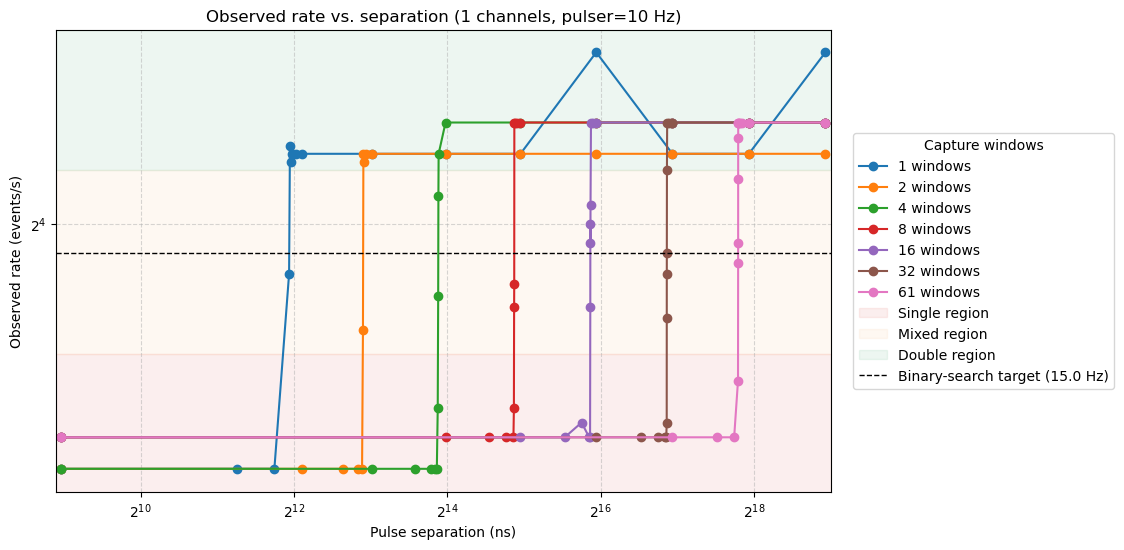

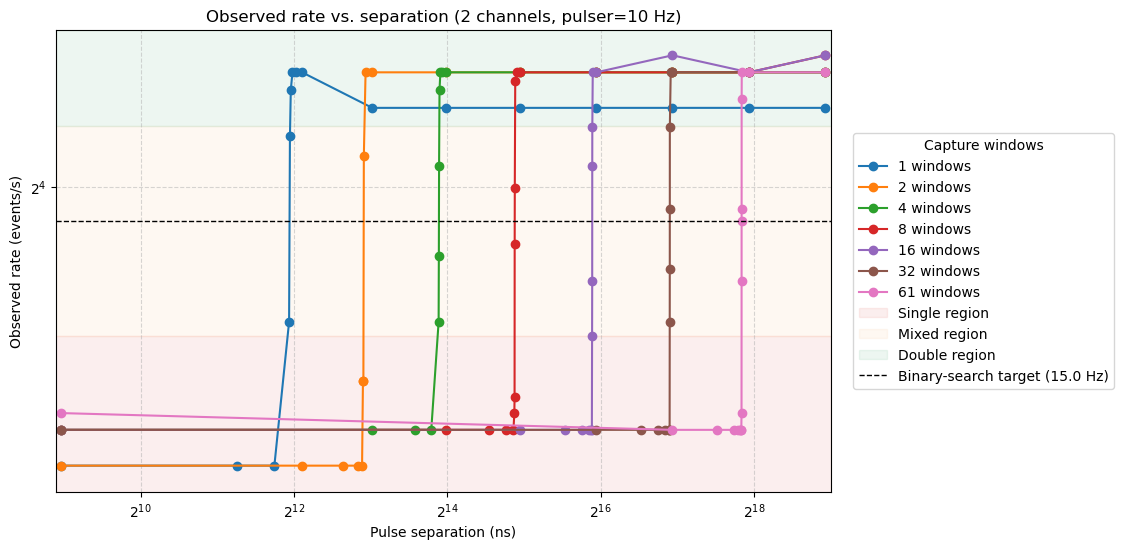

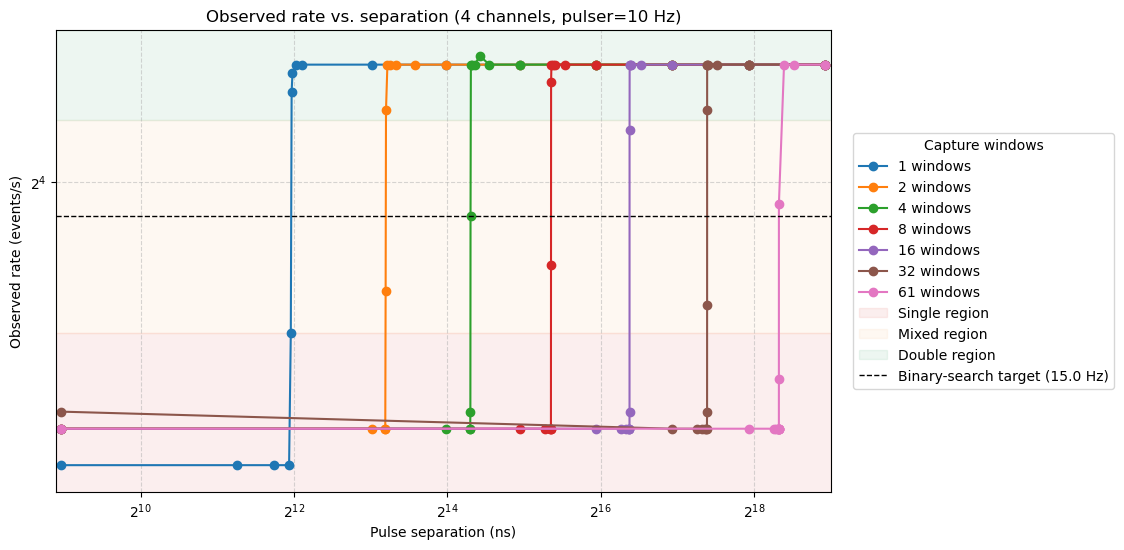

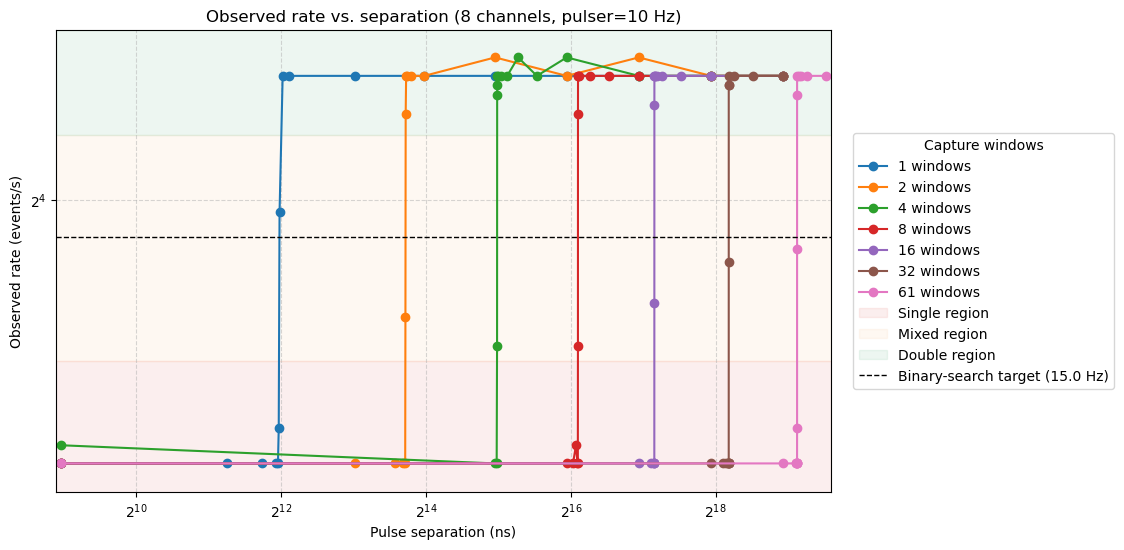

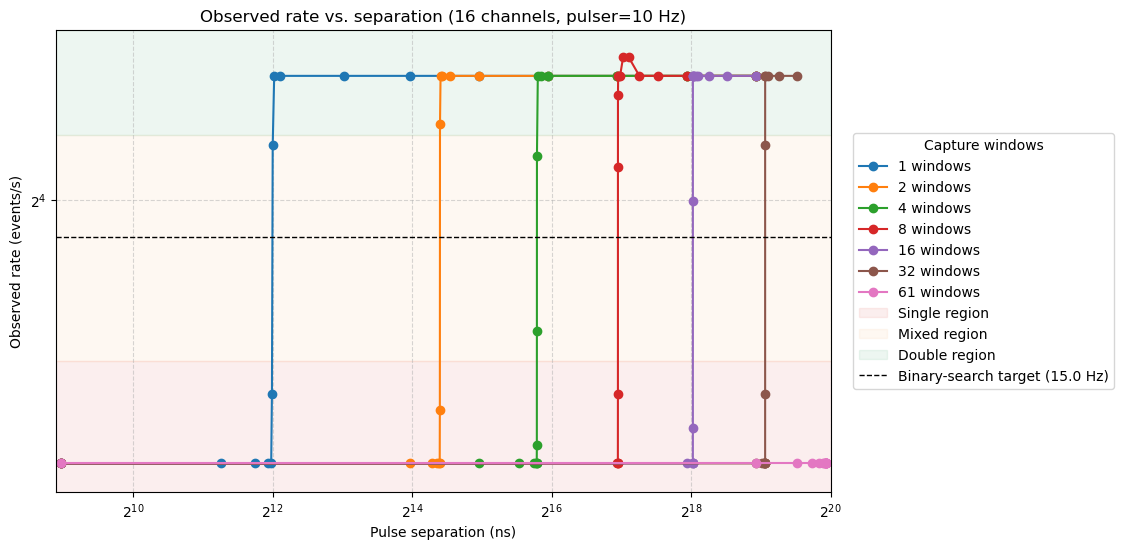

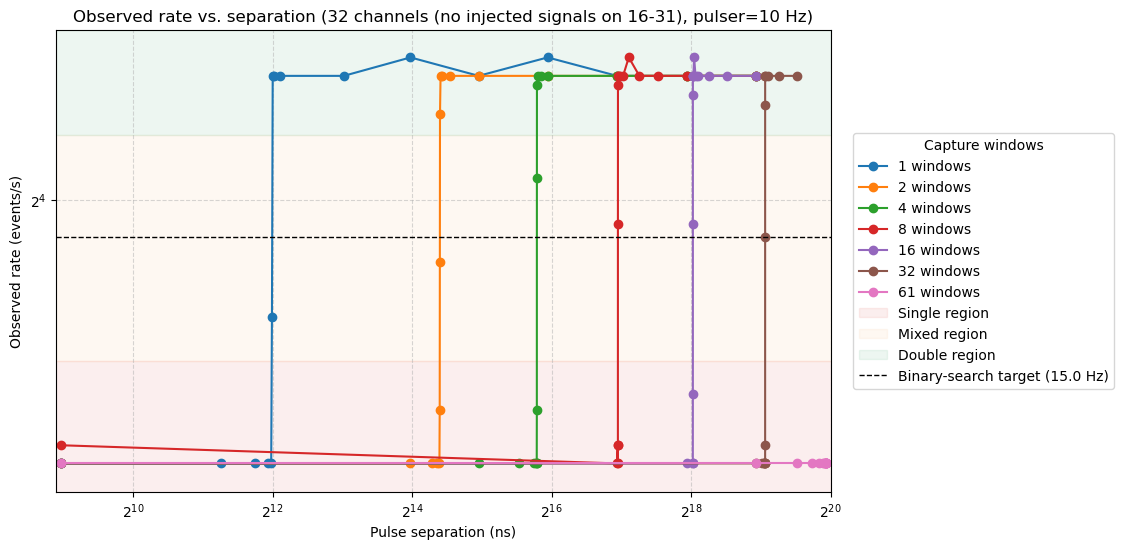

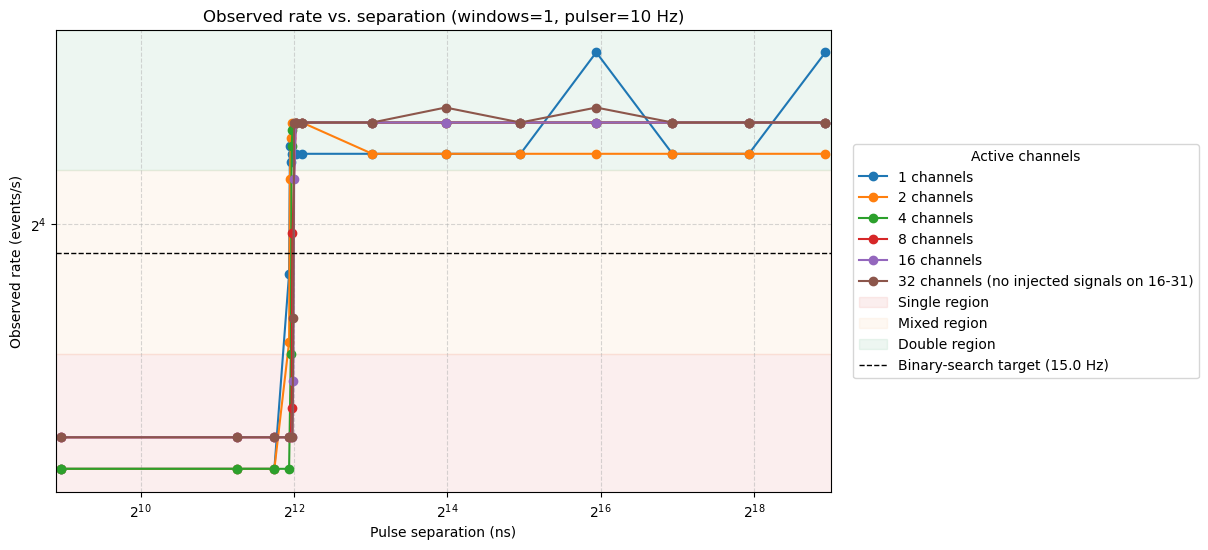

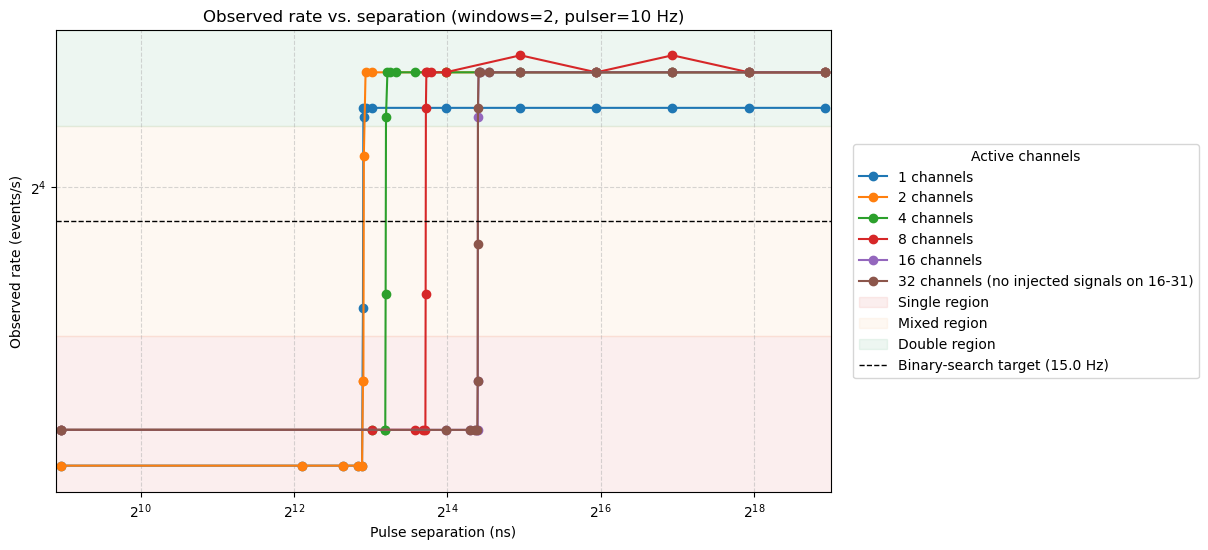

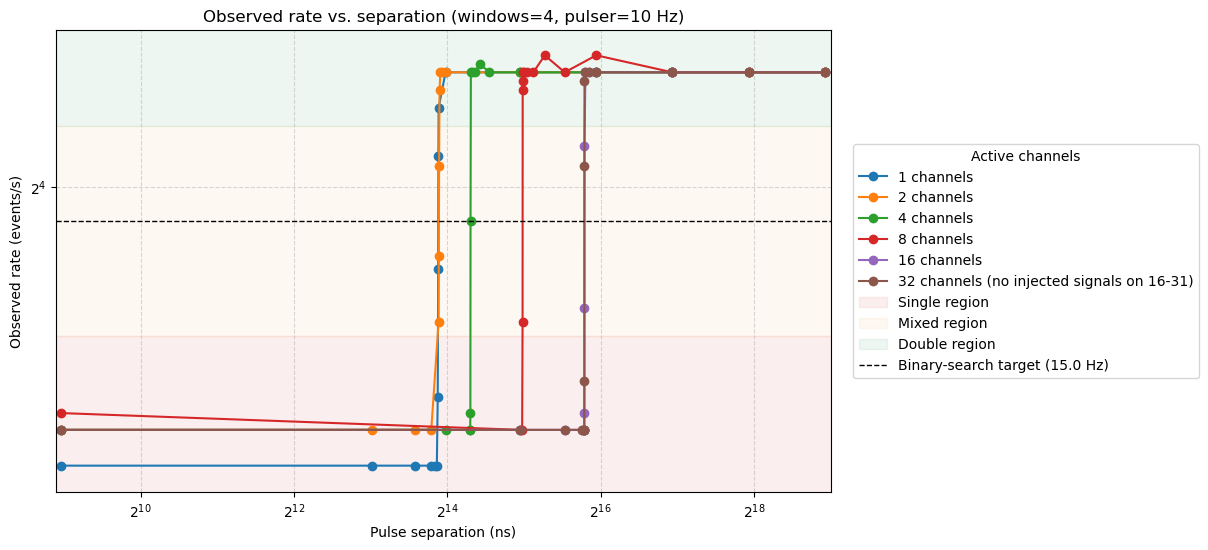

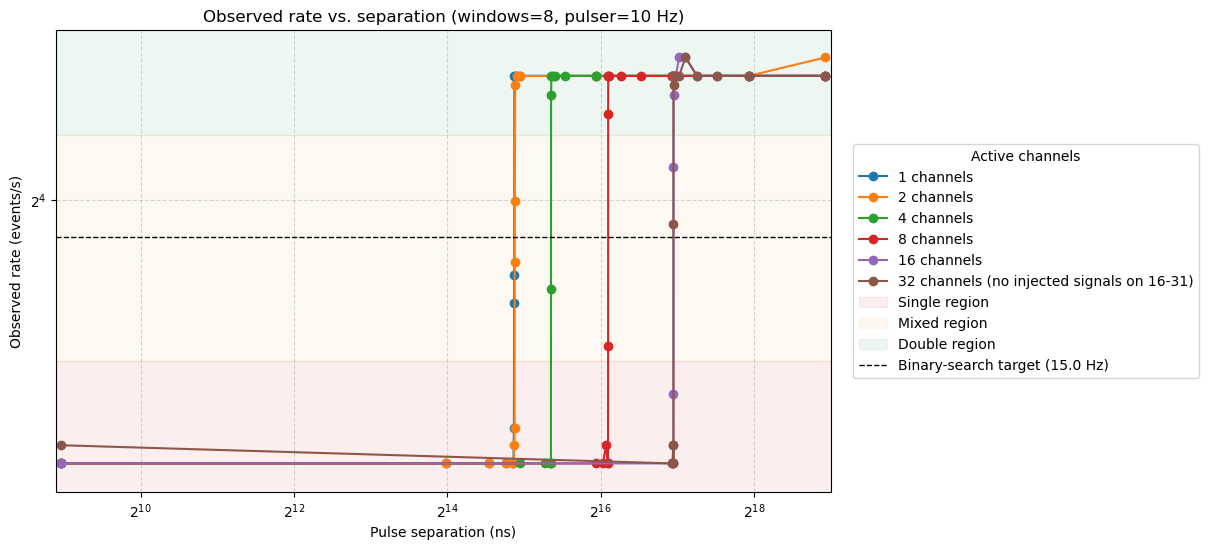

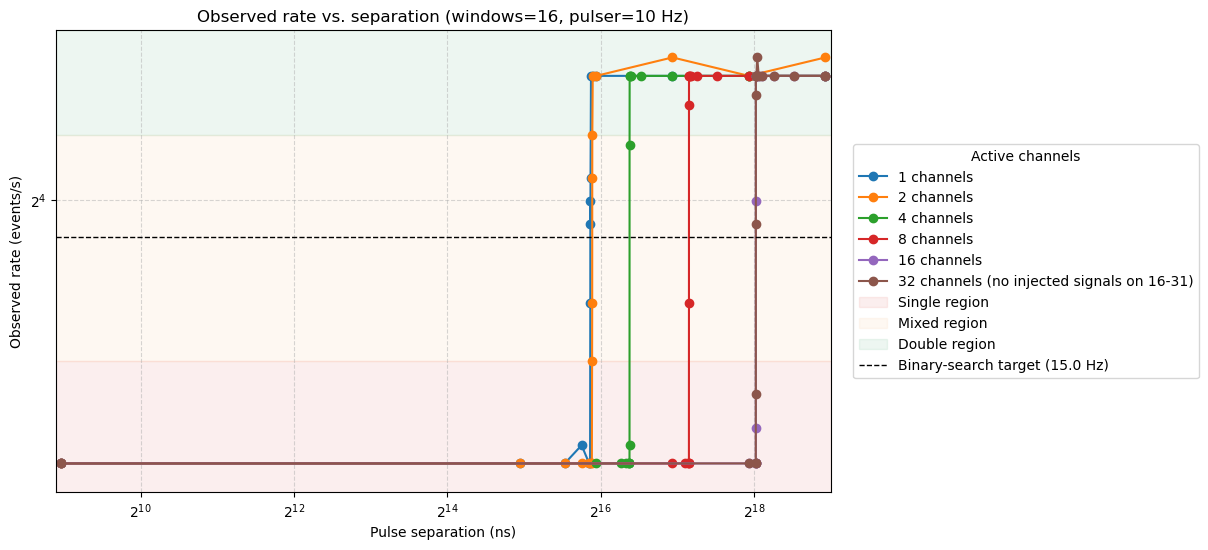

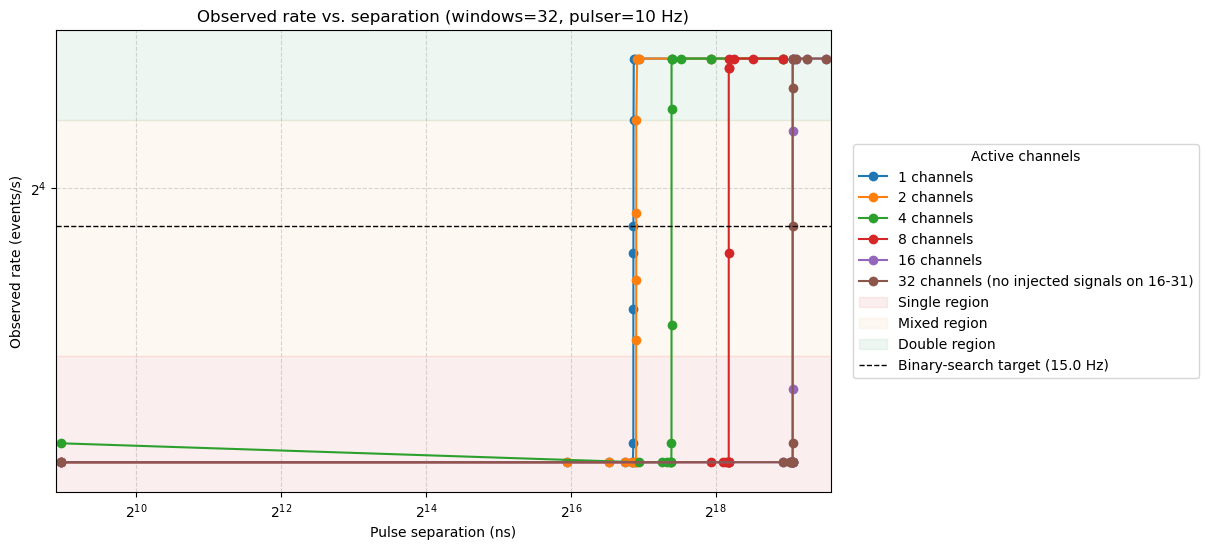

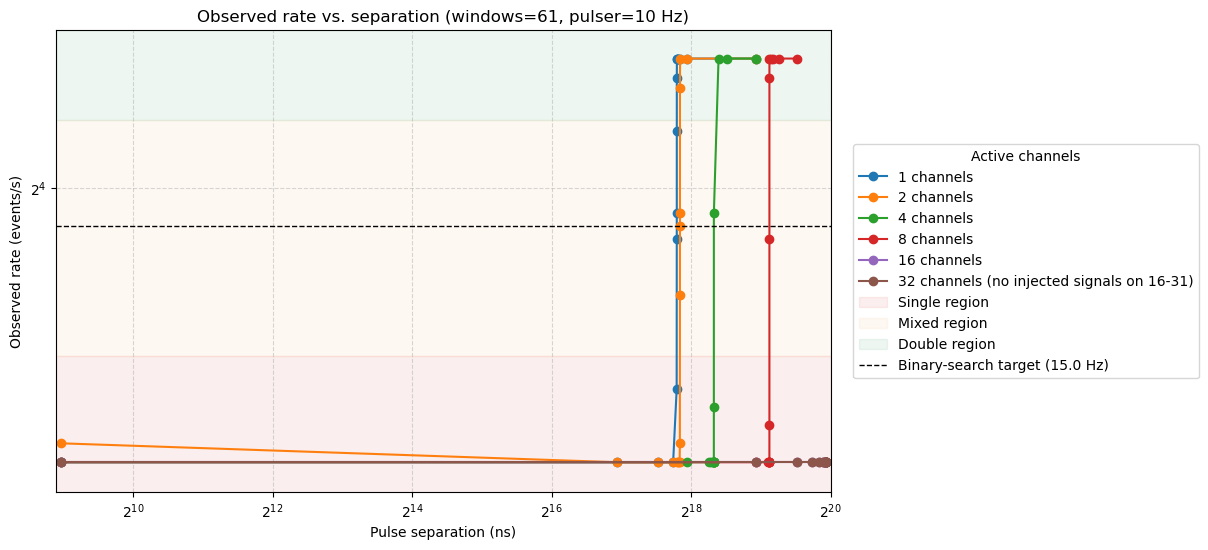

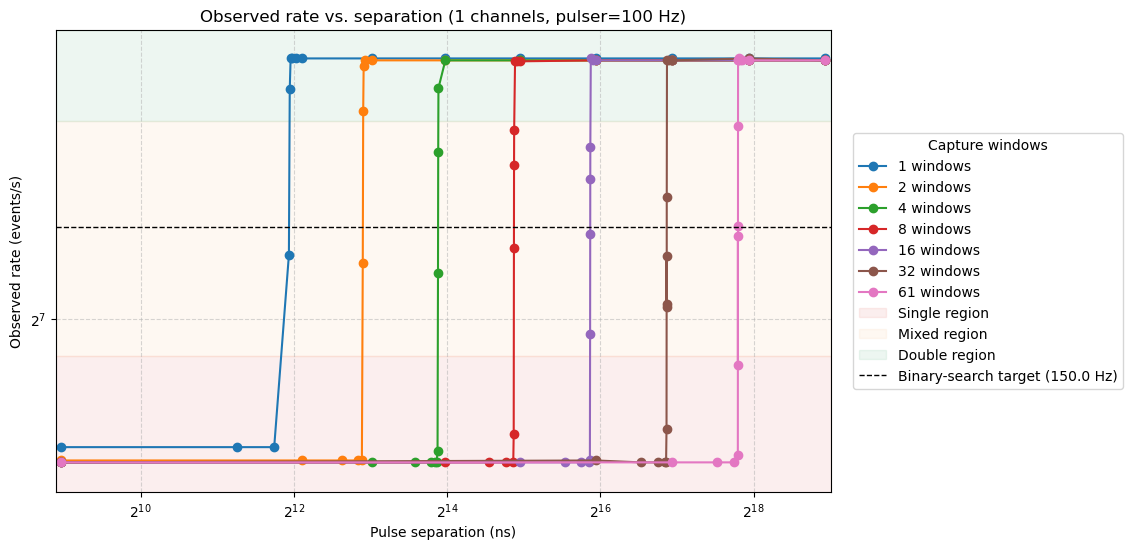

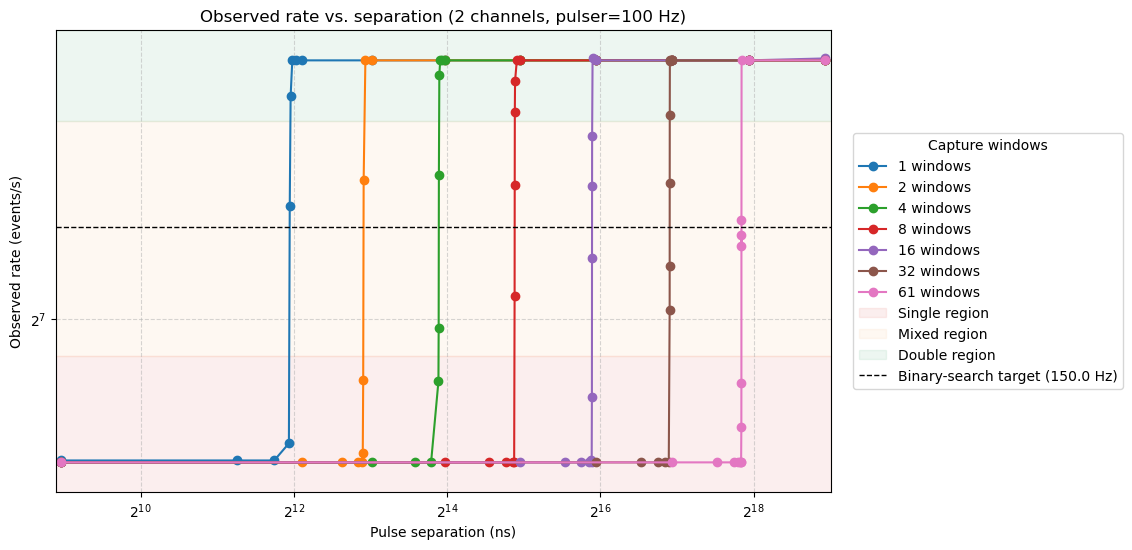

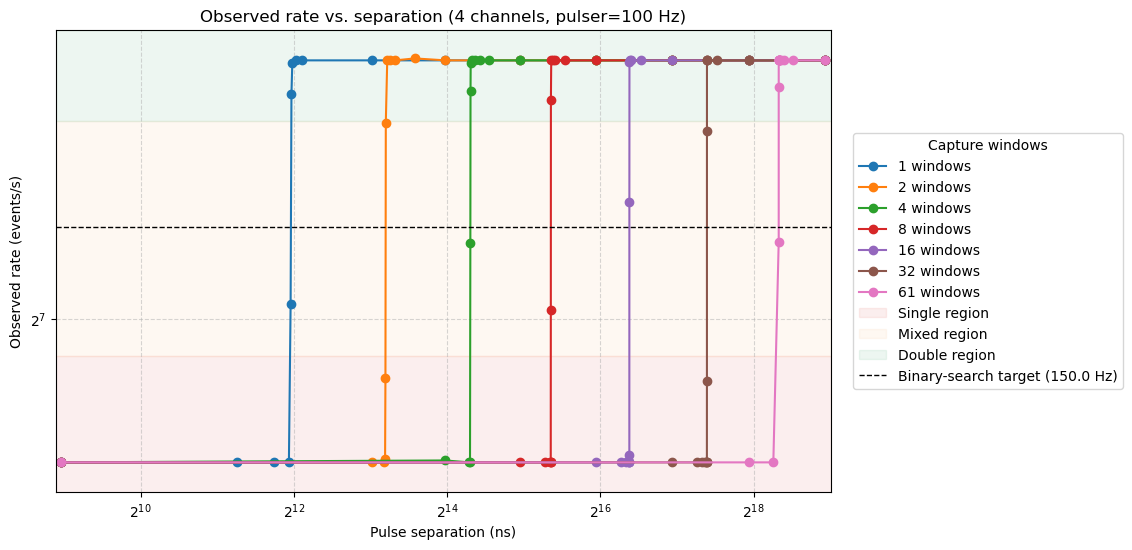

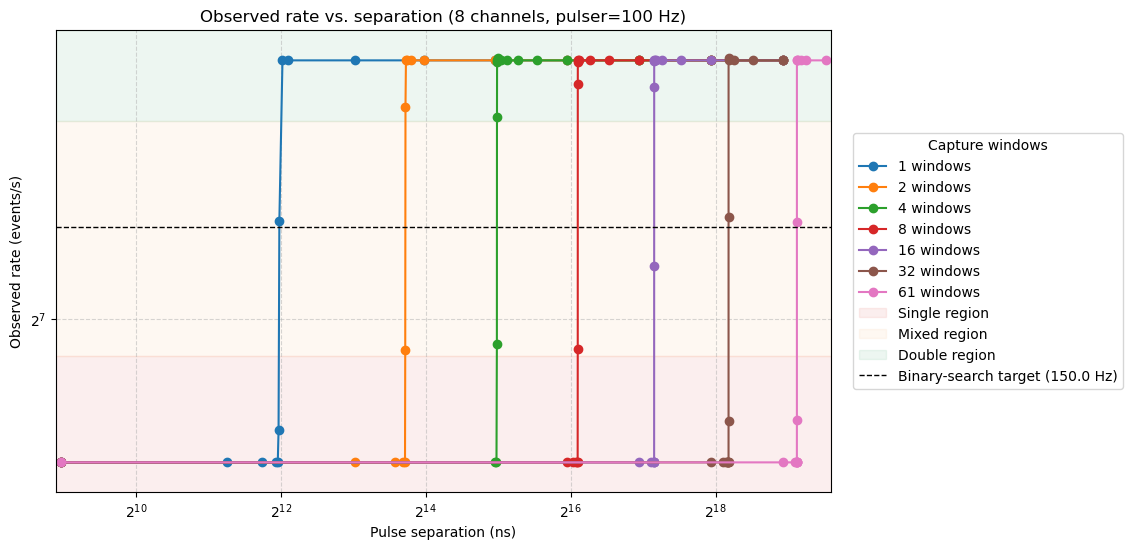

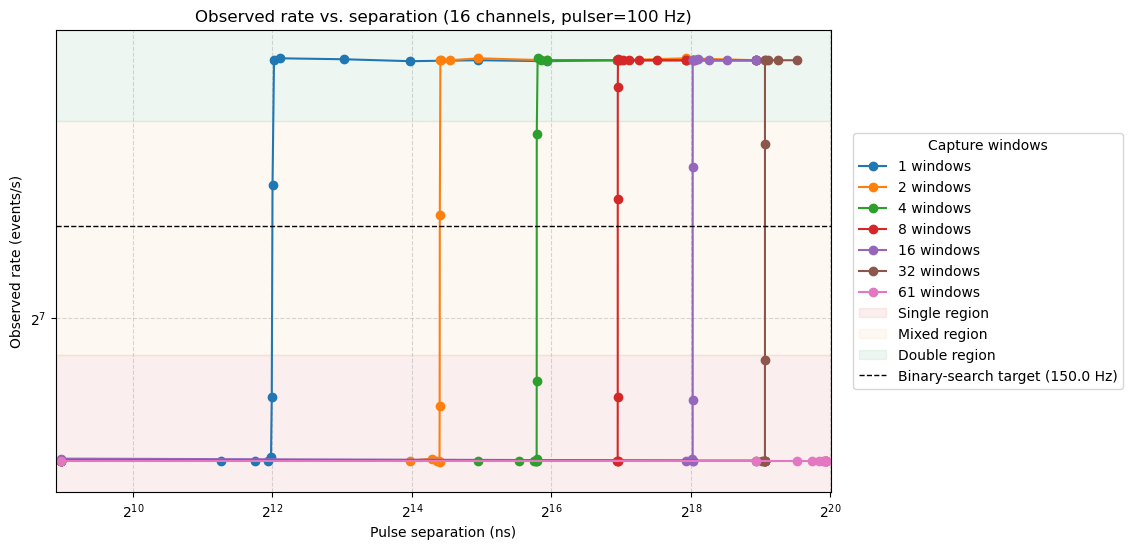

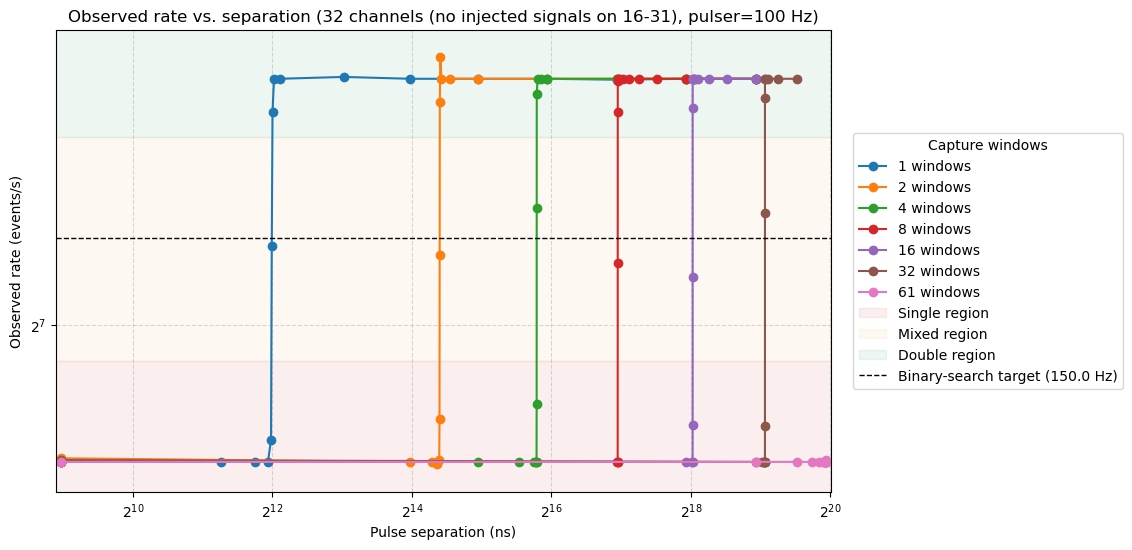

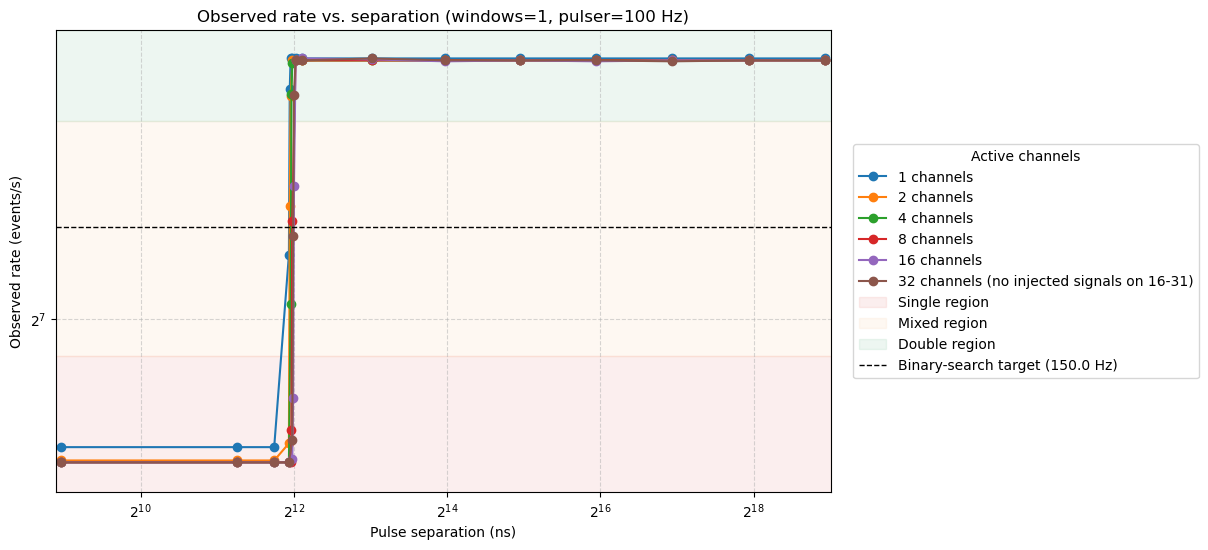

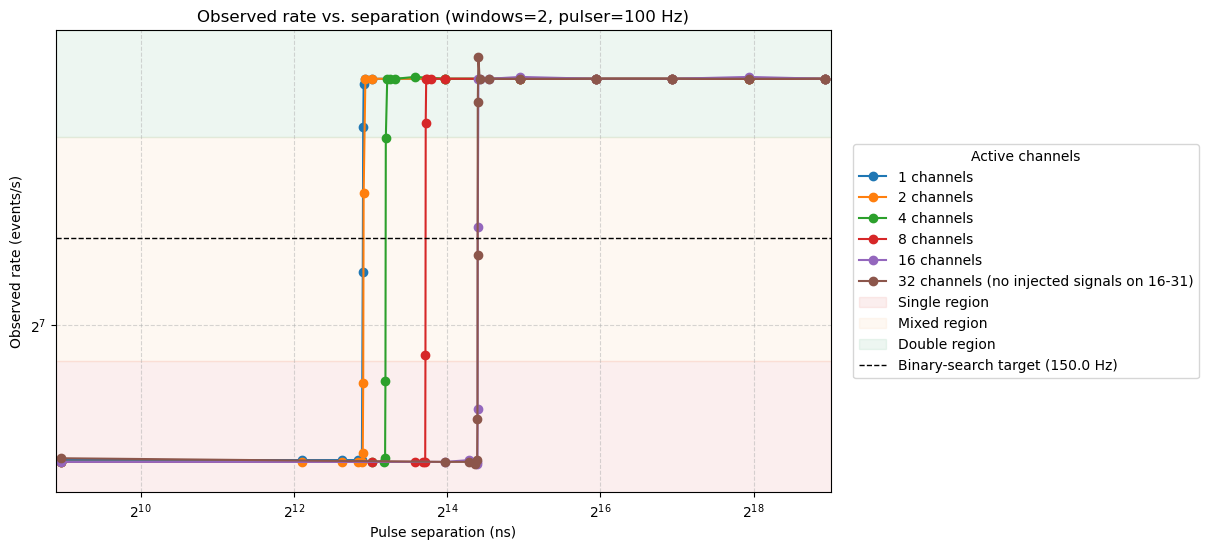

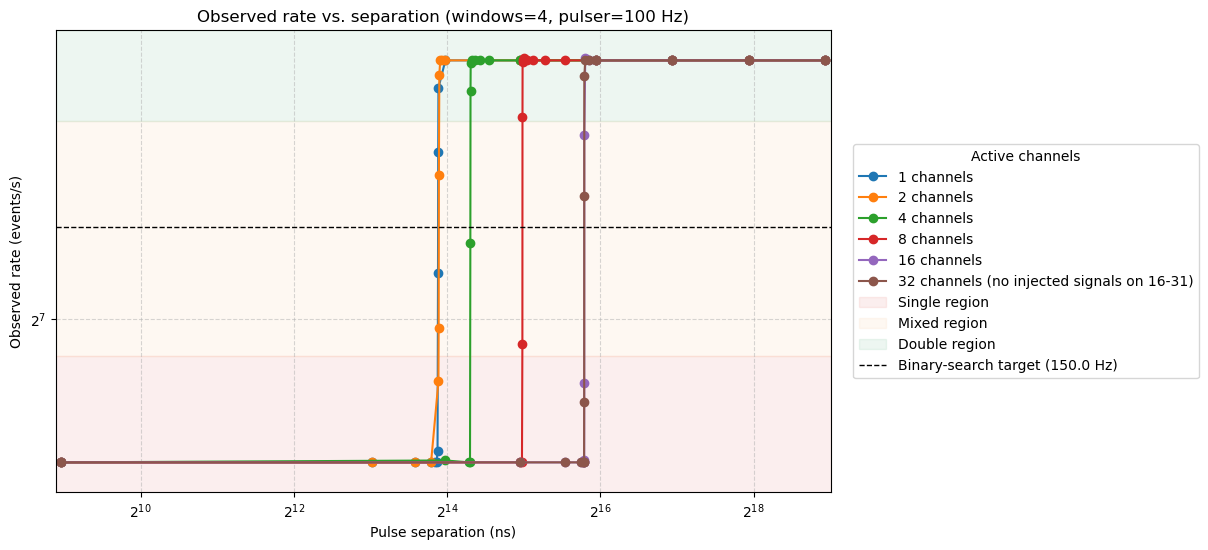

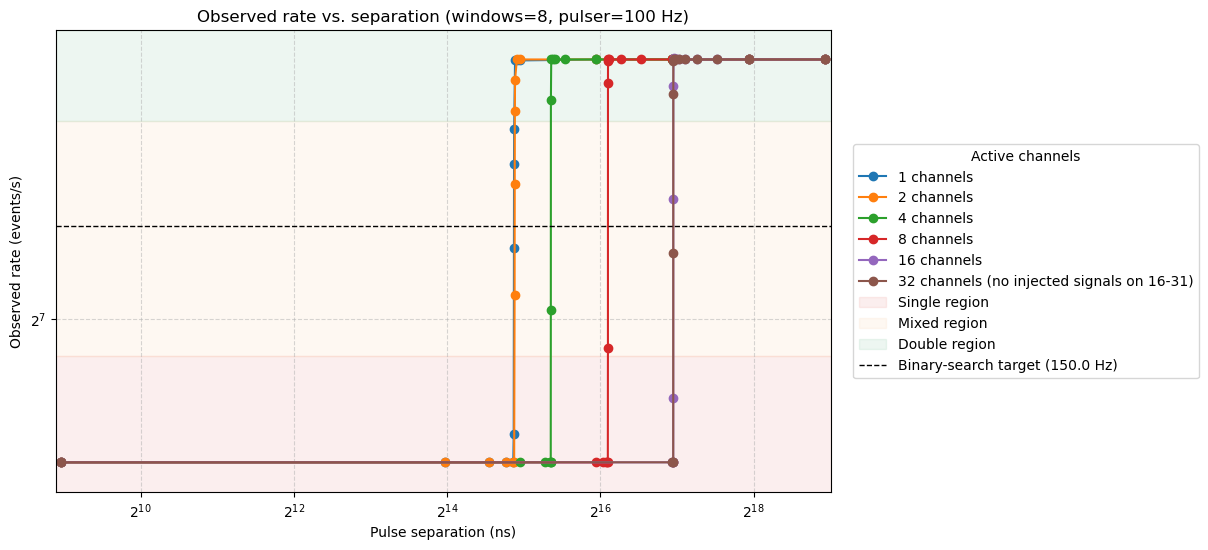

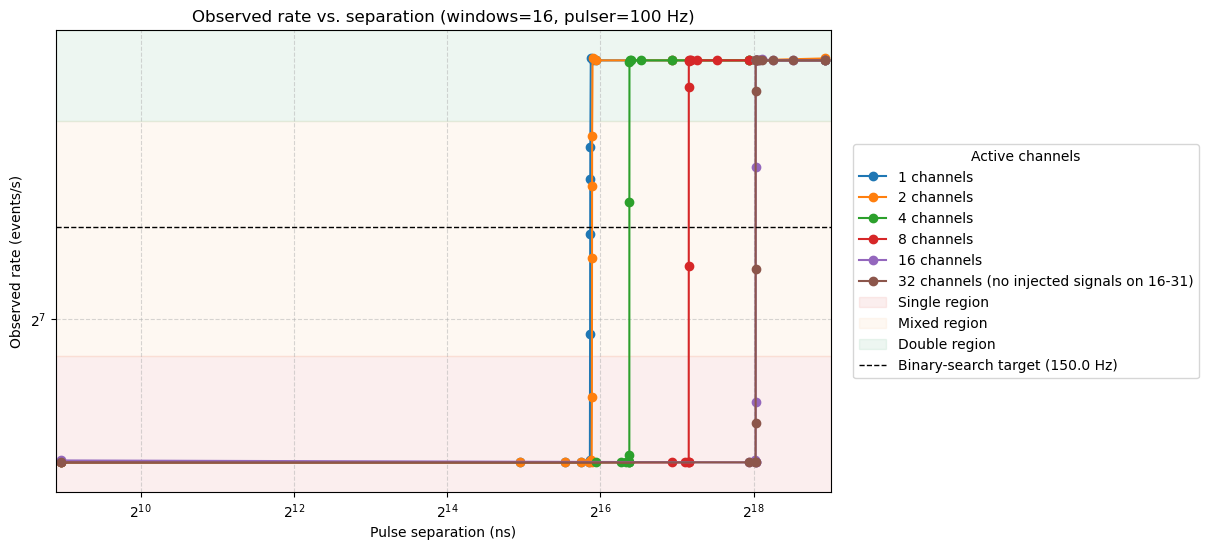

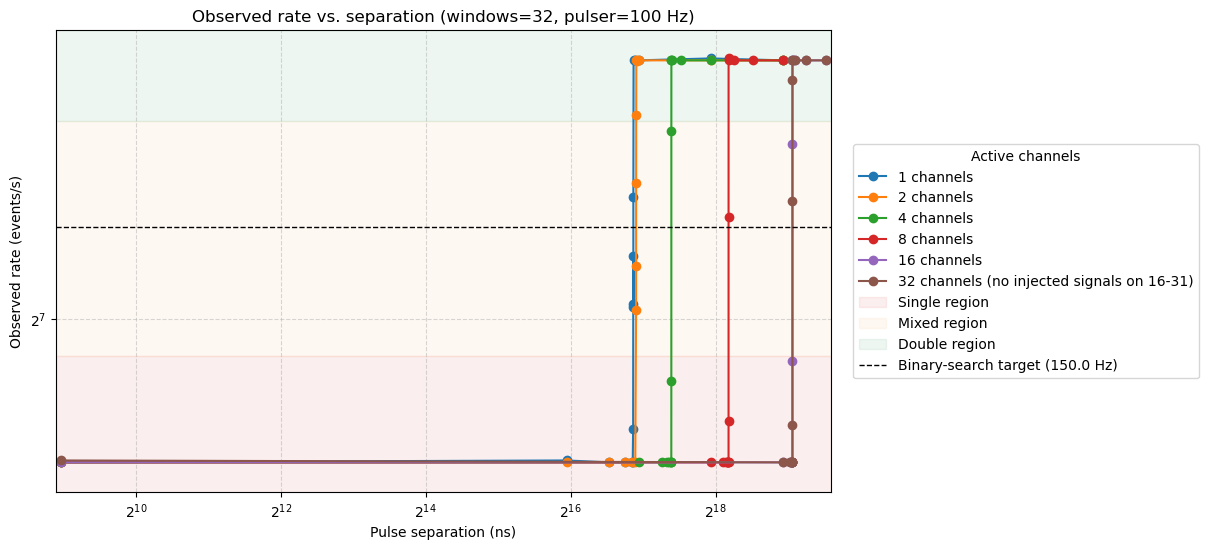

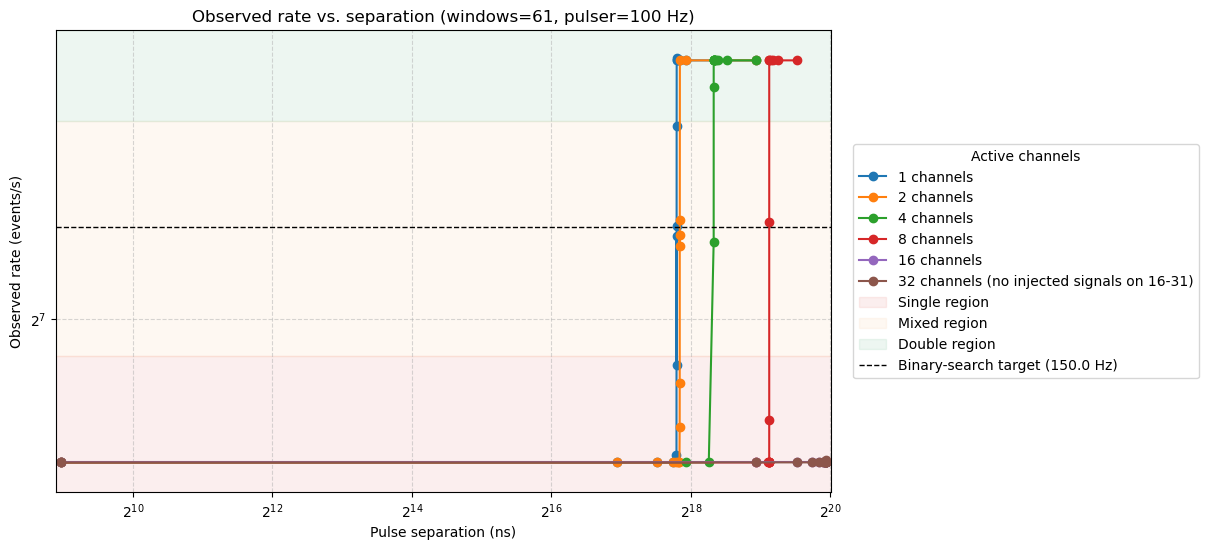

In [2]:
for rate in PULSER_RATES:
    analysis.plot_rate_vs_separation_by_channels(rate)
    analysis.plot_rate_vs_separation_by_windows(rate)


## Tertiary outcome vs. separation
Categorical view of single / mixed / double classifications based on the 1.2× / 1.8× pulser rate thresholds.

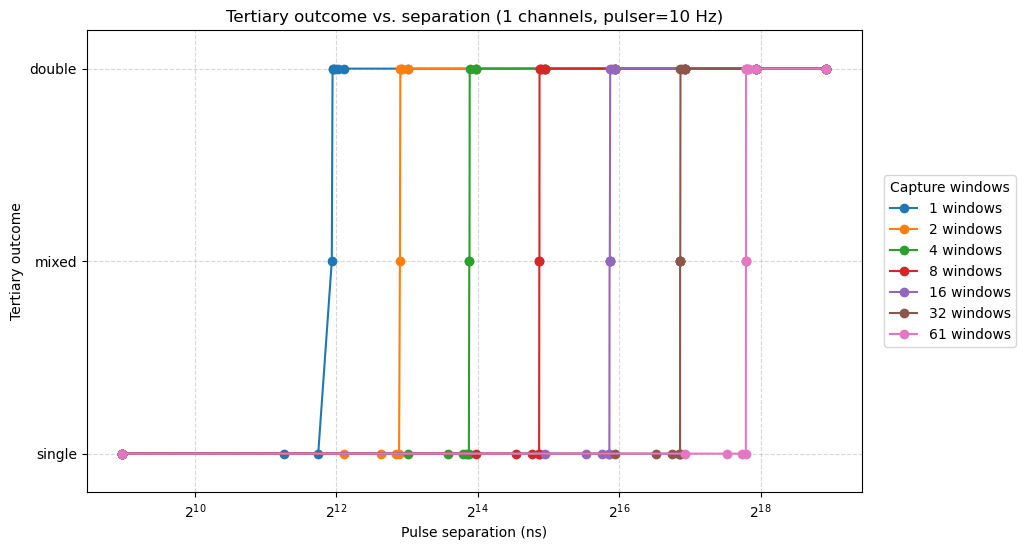

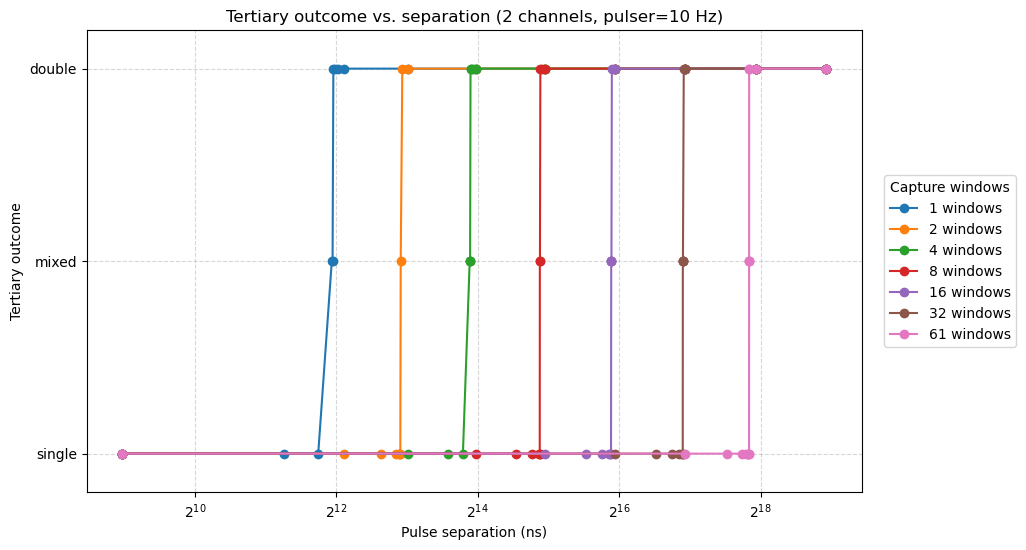

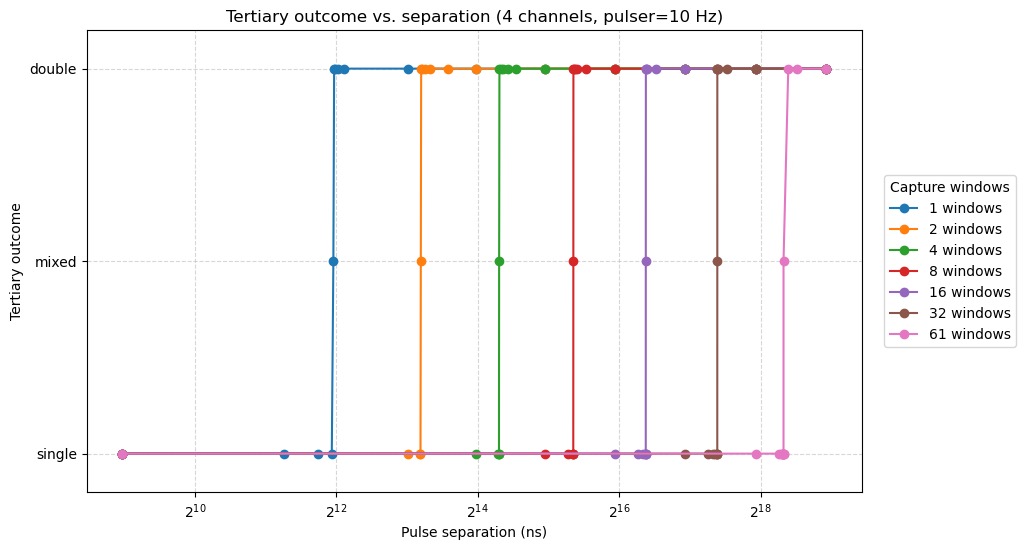

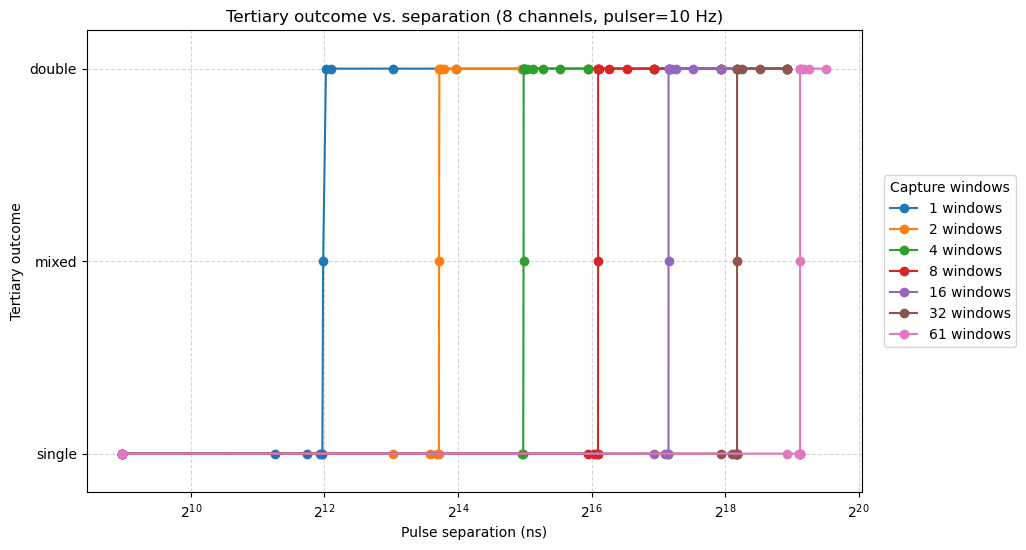

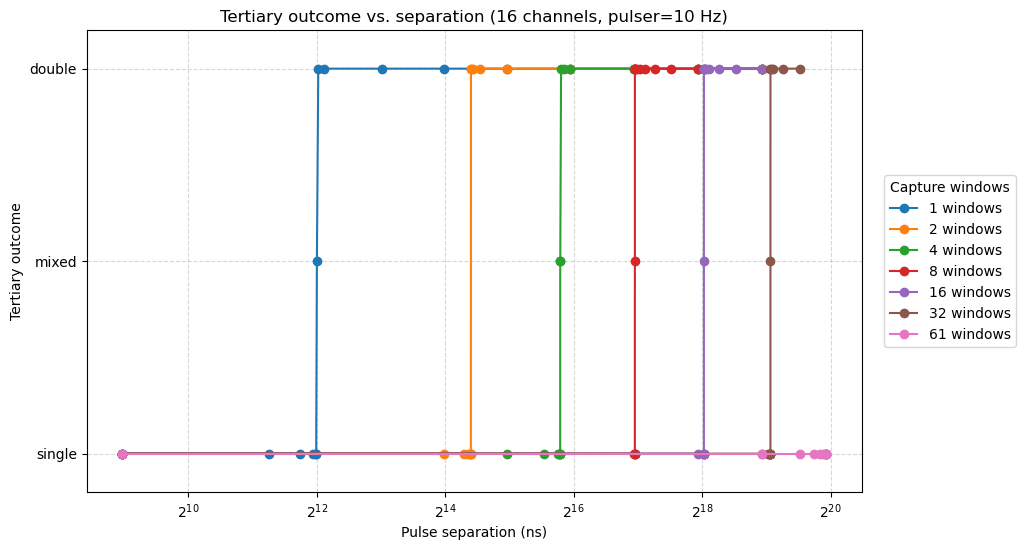

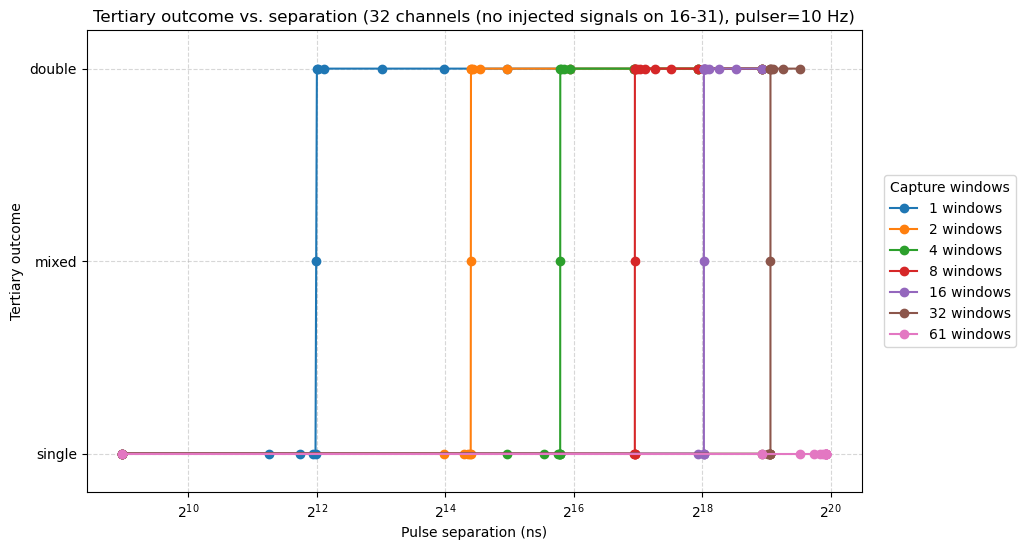

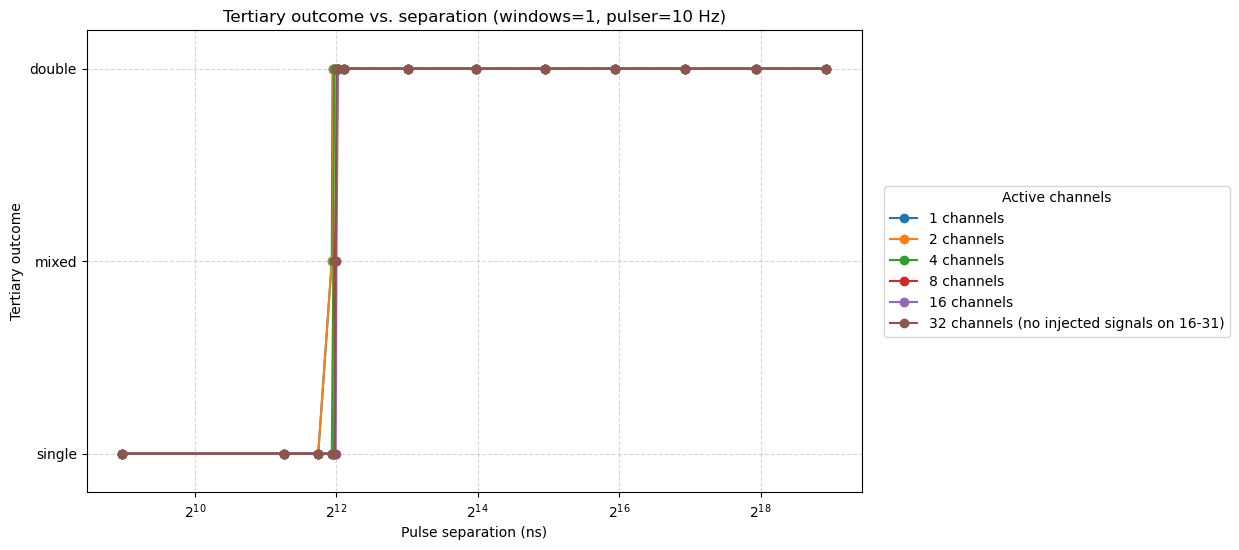

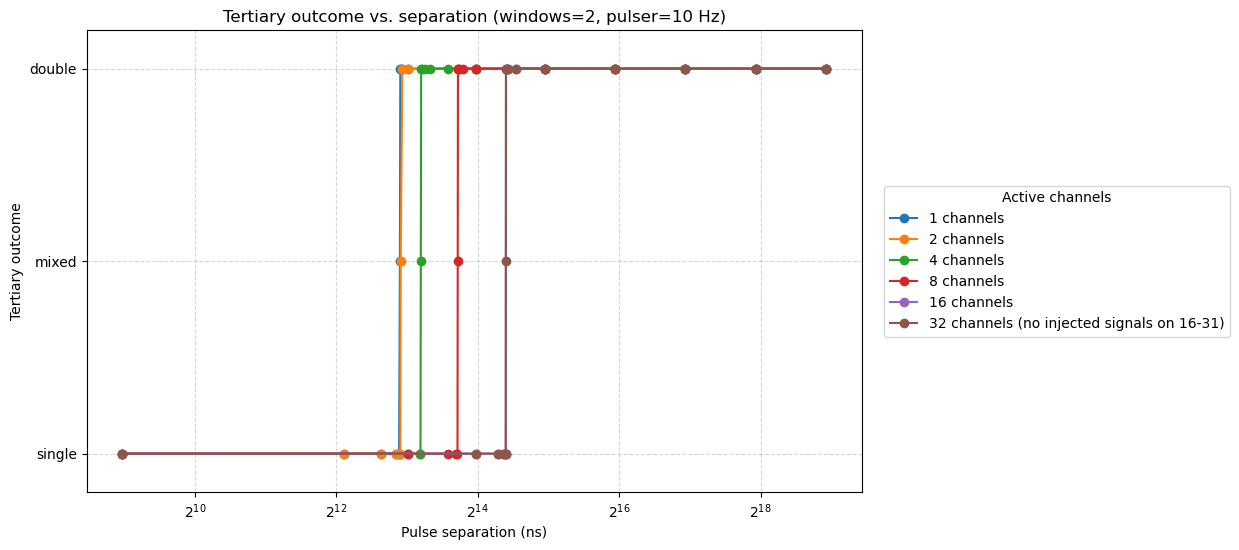

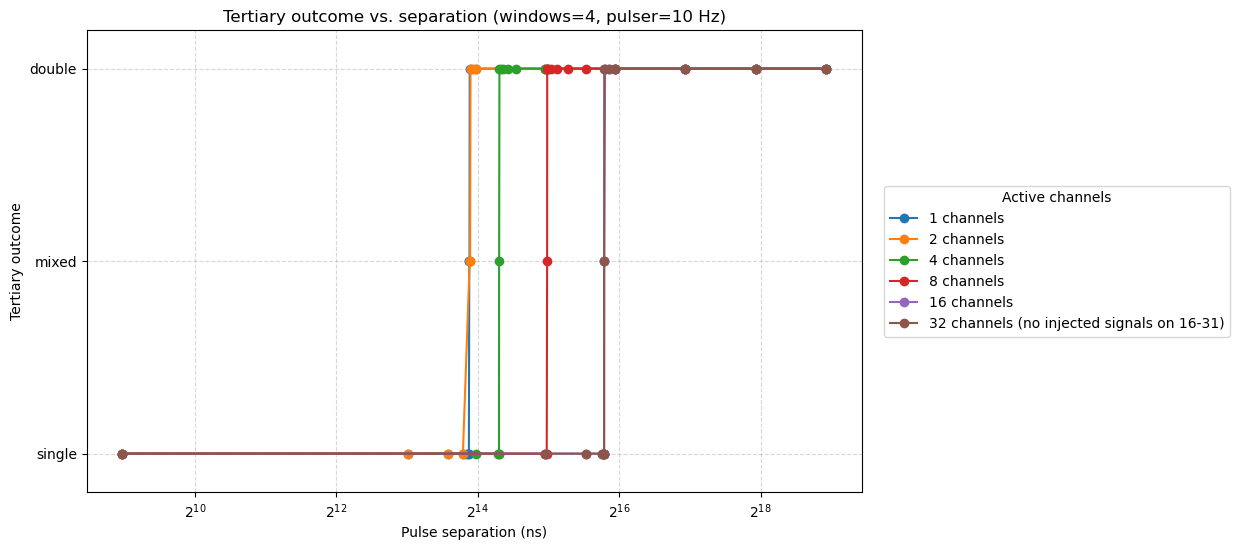

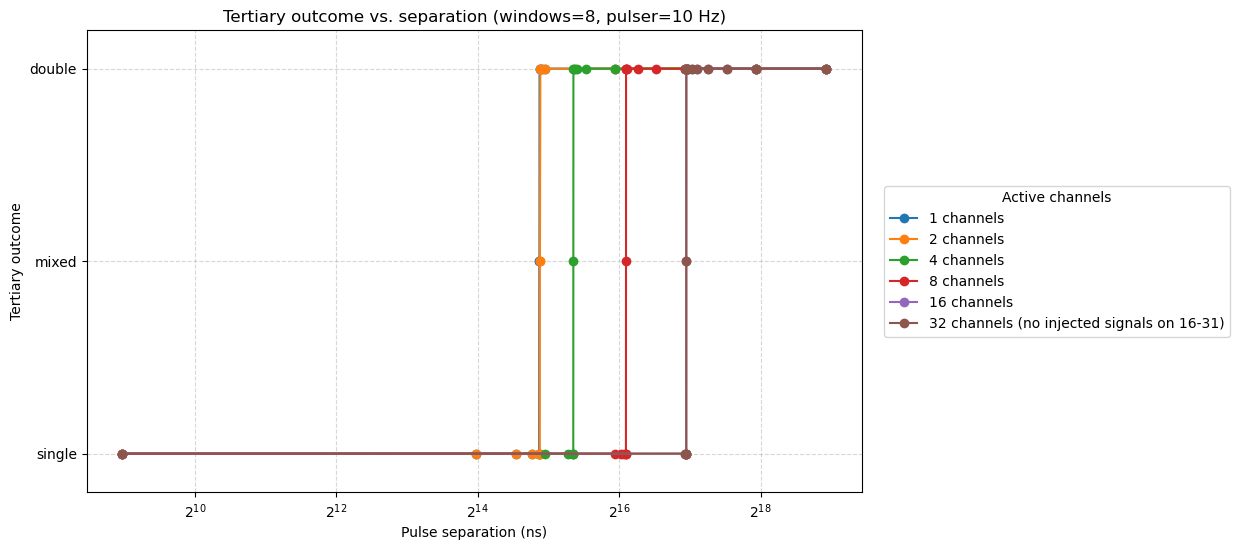

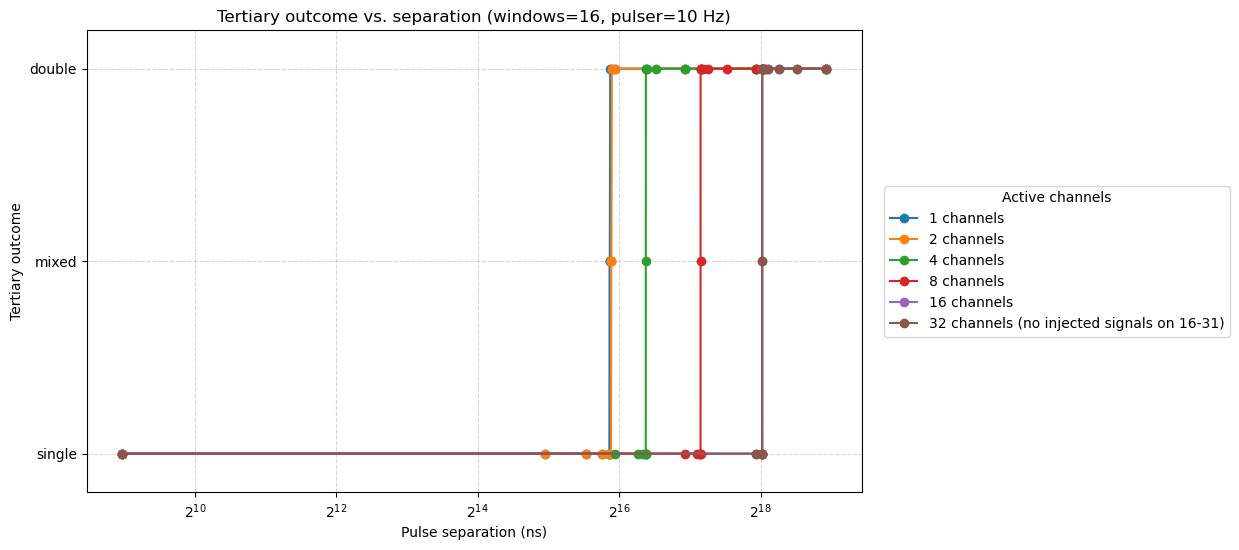

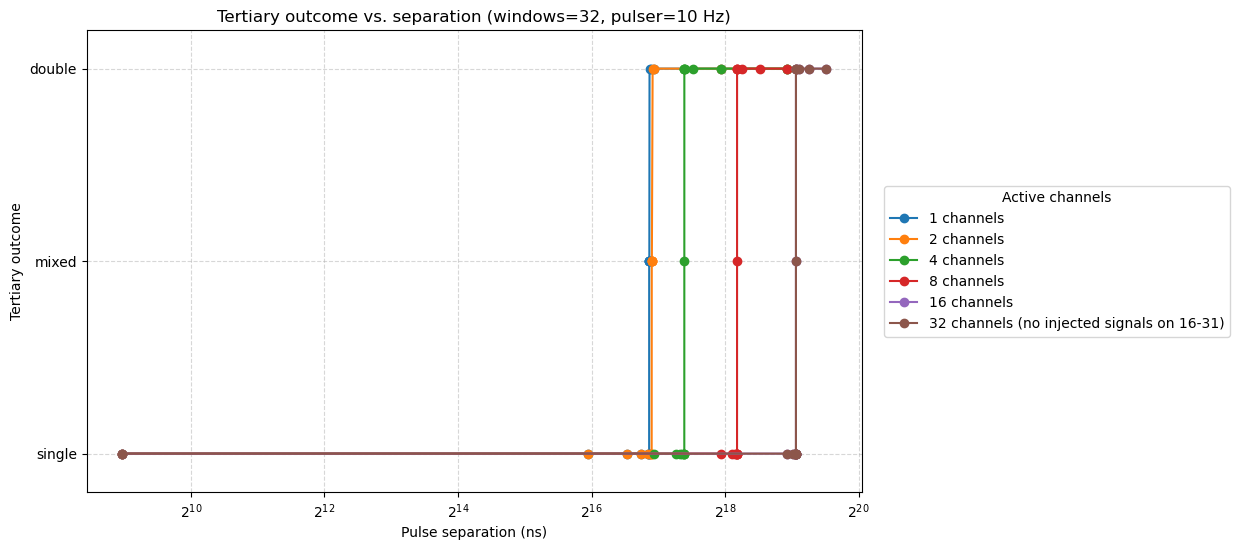

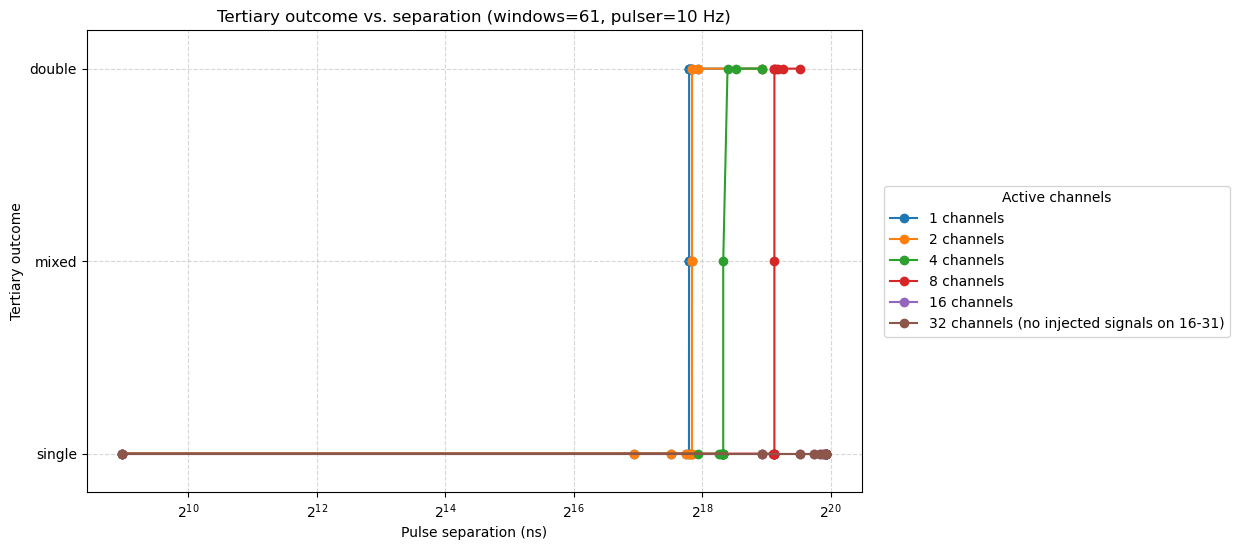

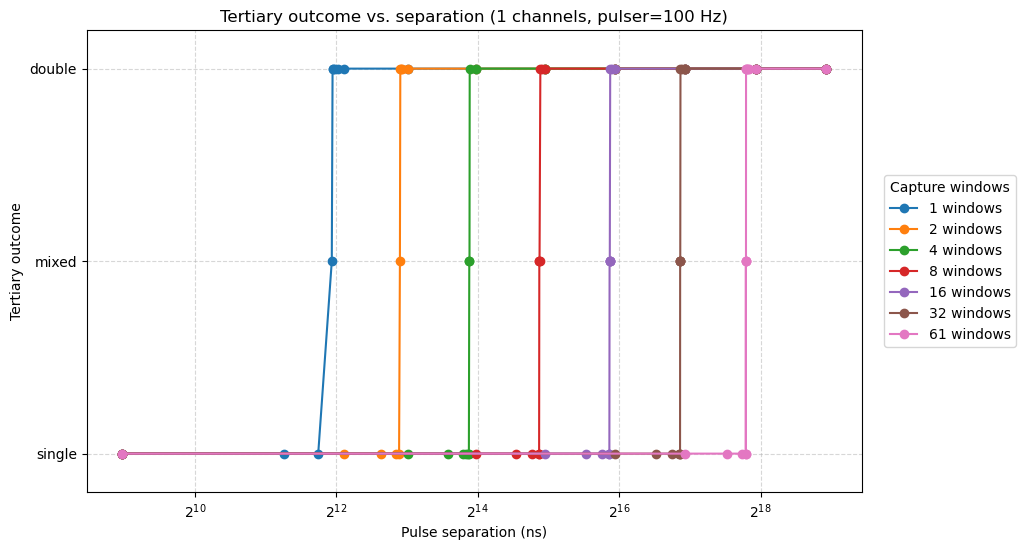

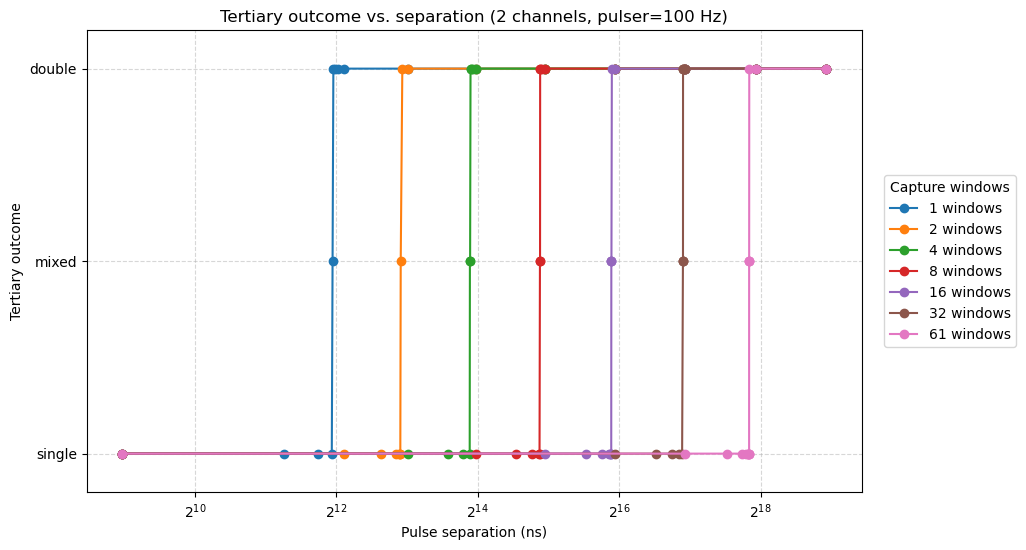

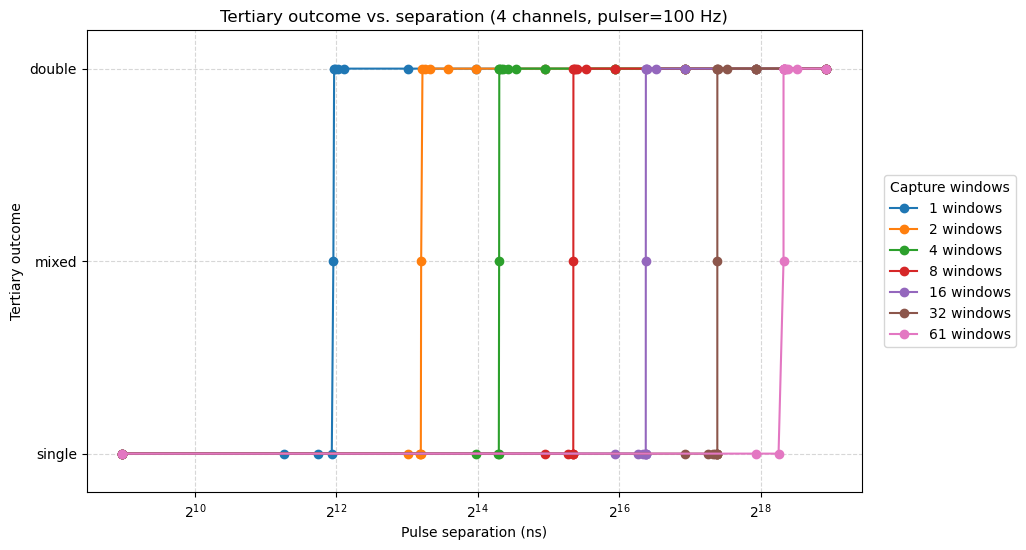

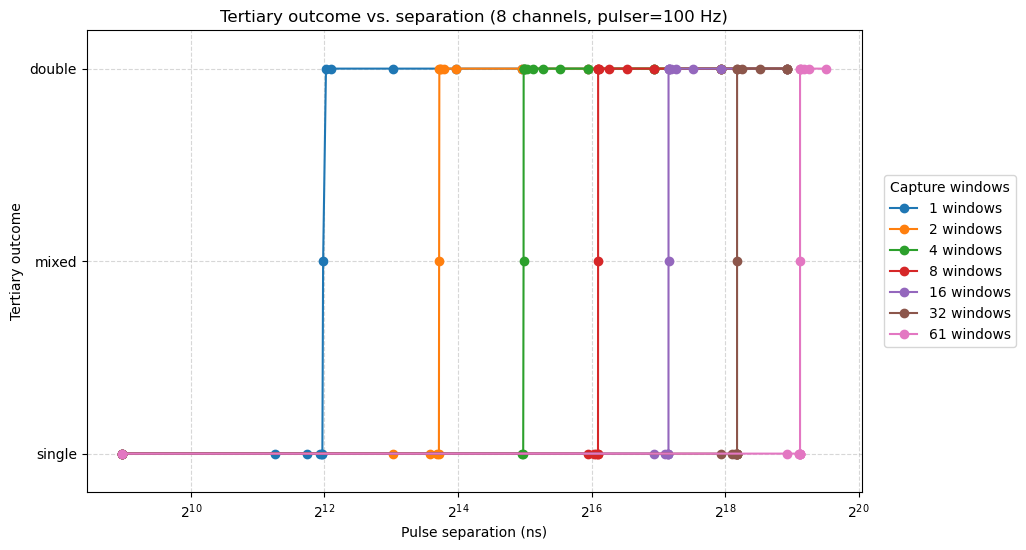

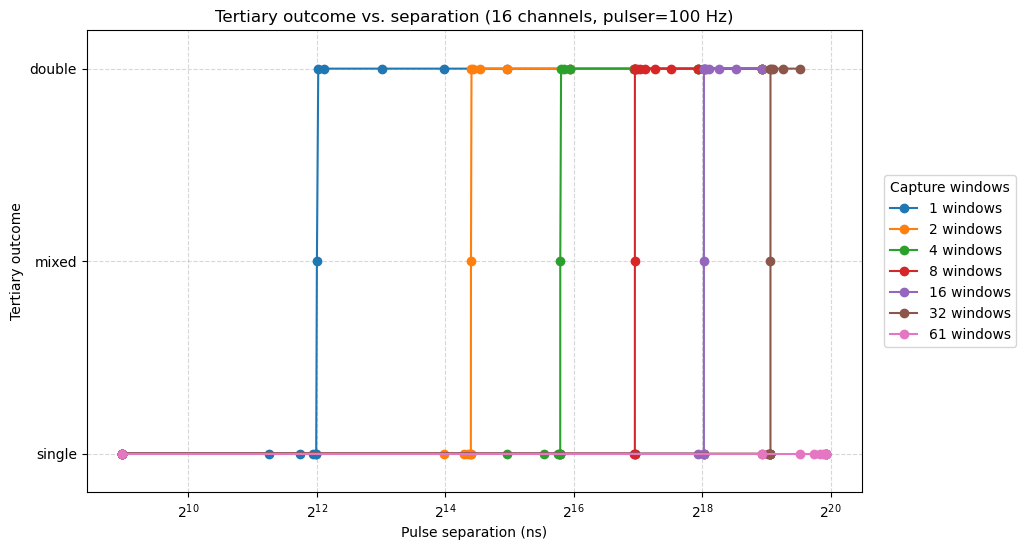

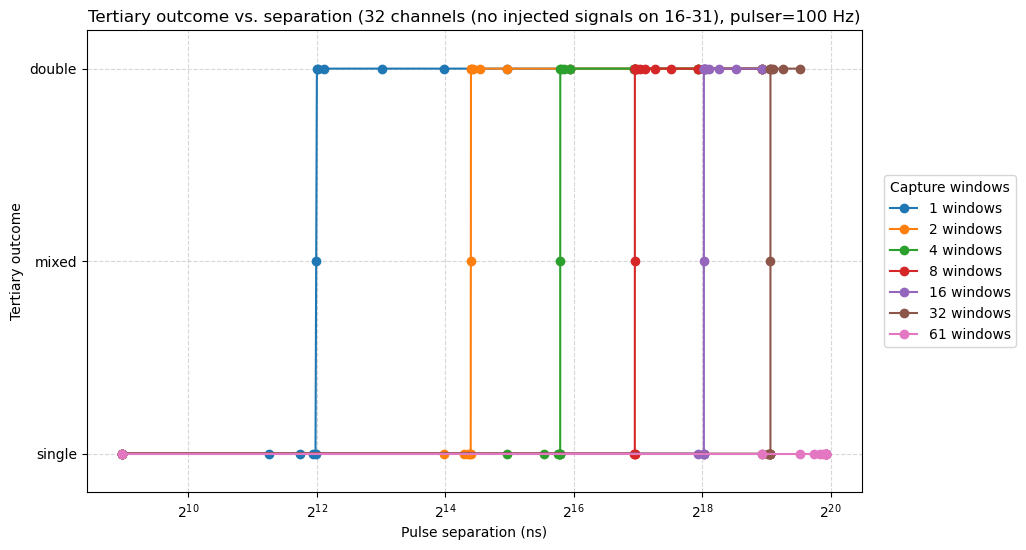

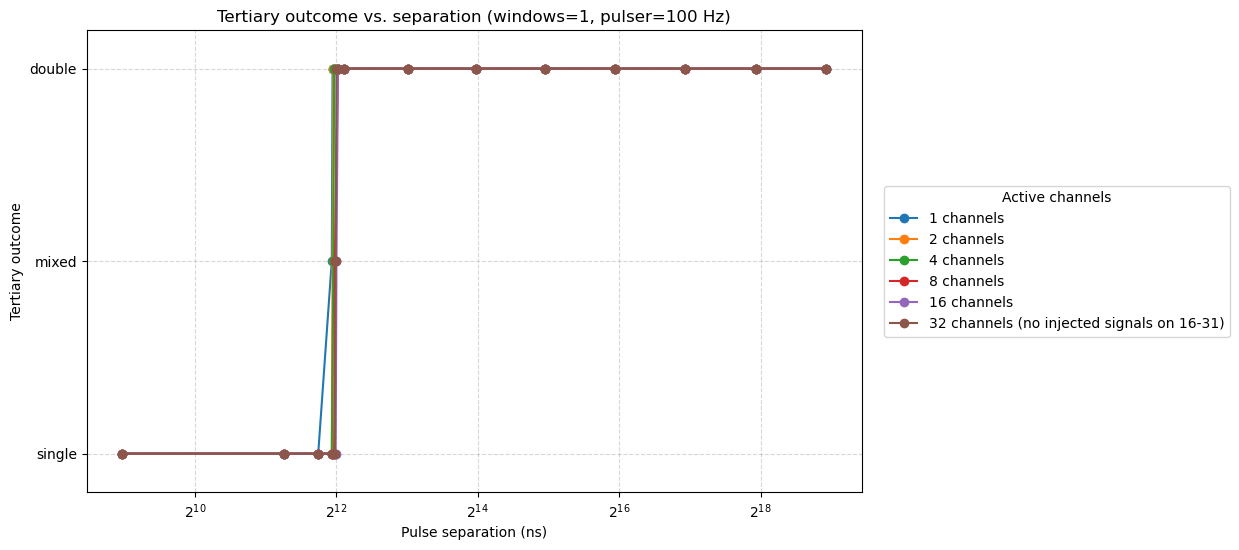

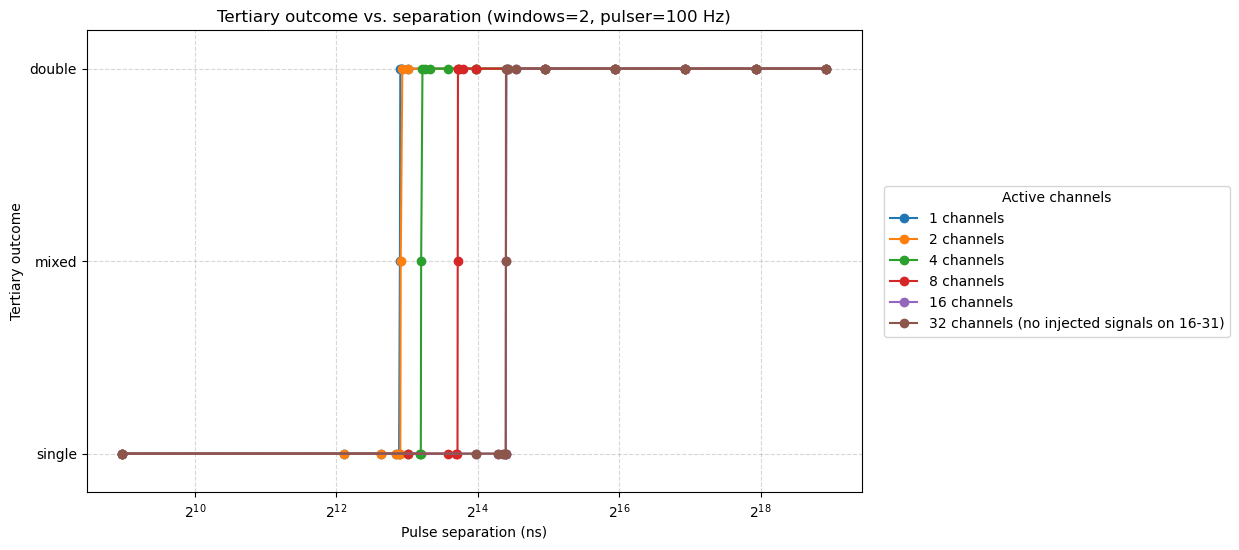

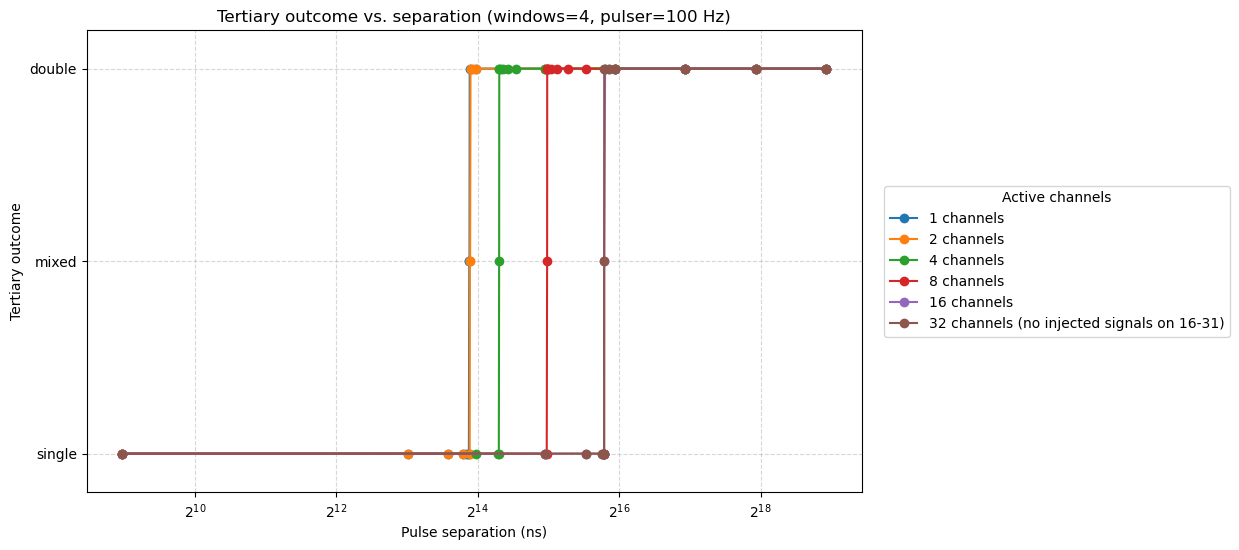

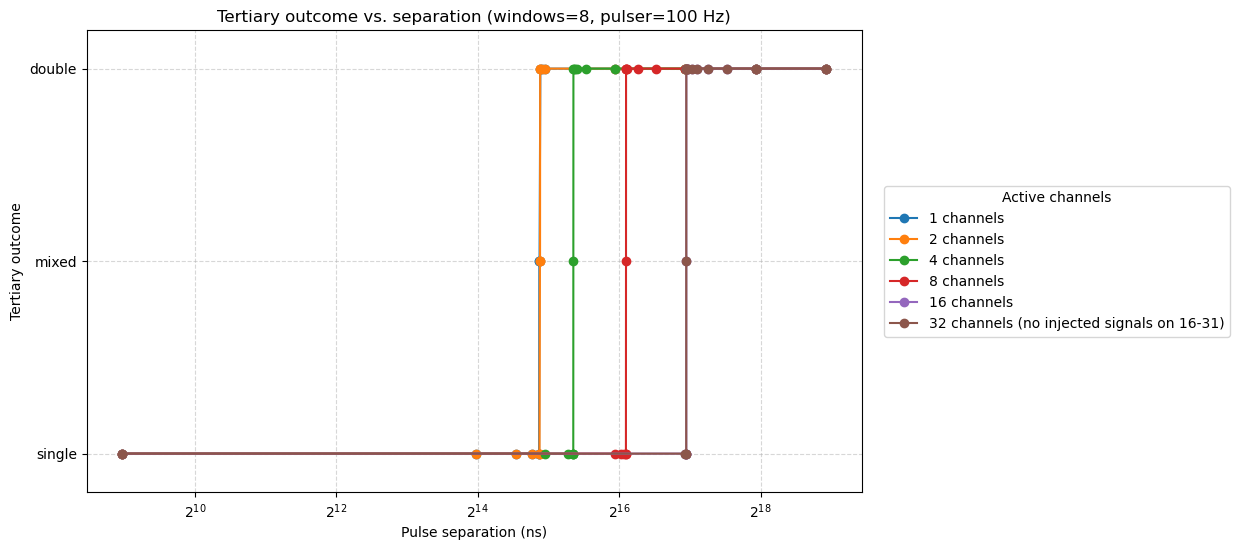

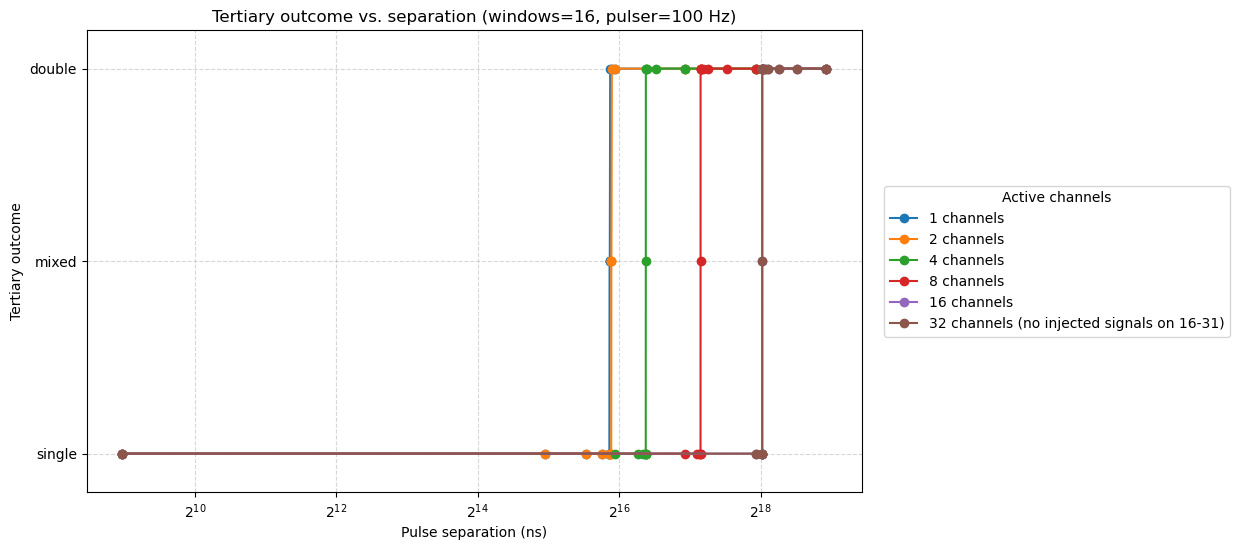

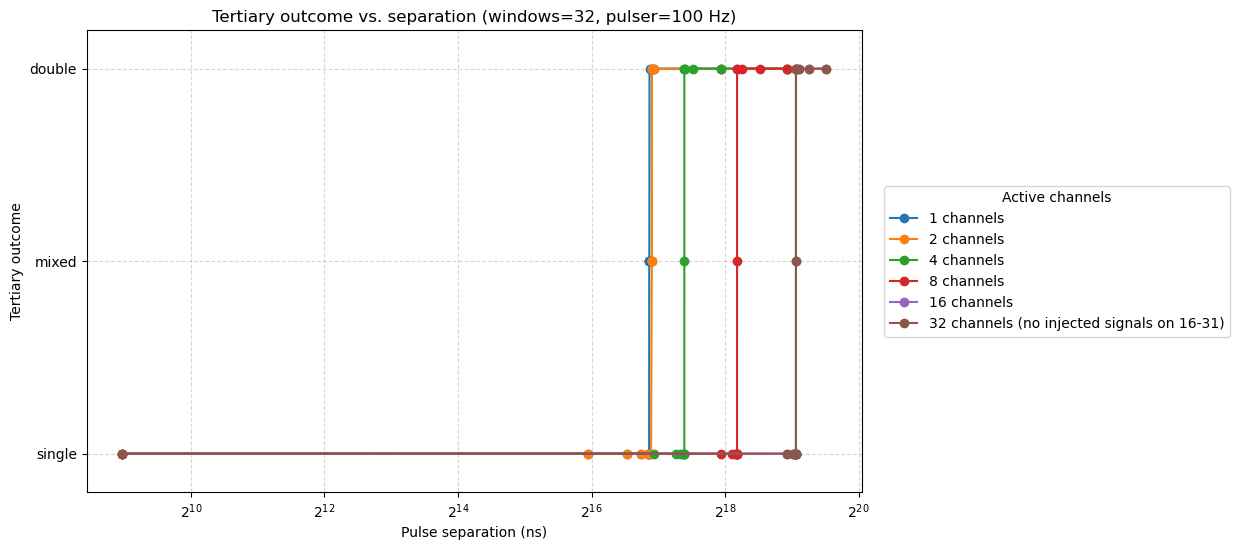

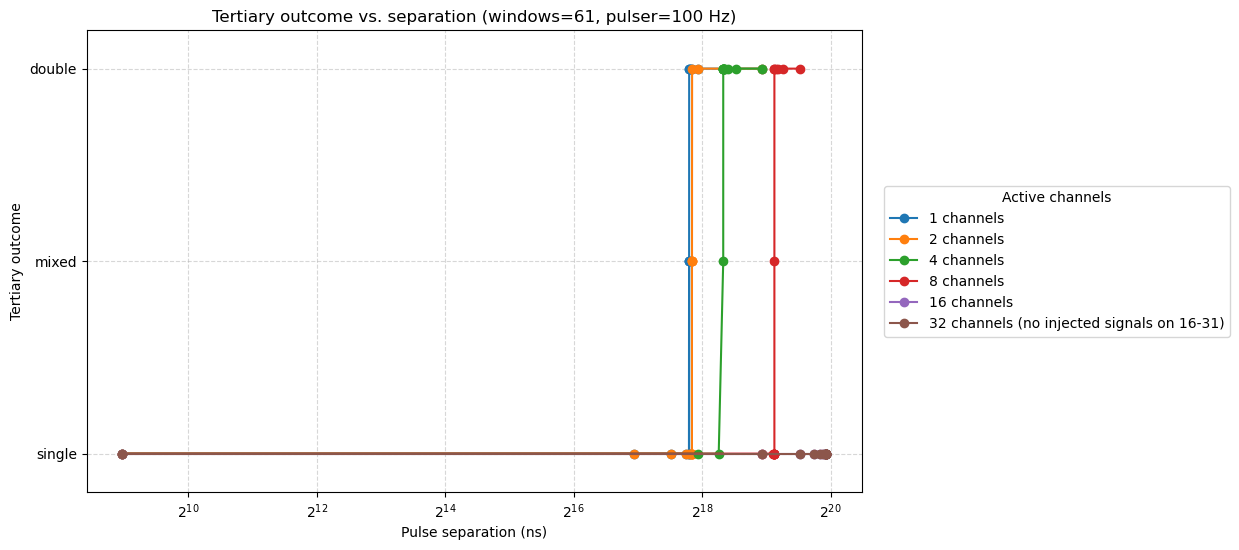

In [3]:
for rate in PULSER_RATES:
    analysis.plot_tertiary_vs_separation_by_channels(rate)
    analysis.plot_tertiary_vs_separation_by_windows(rate)


## Converged separation vs. capture windows
Includes both pulser rates on the same axes for side-by-side comparison.

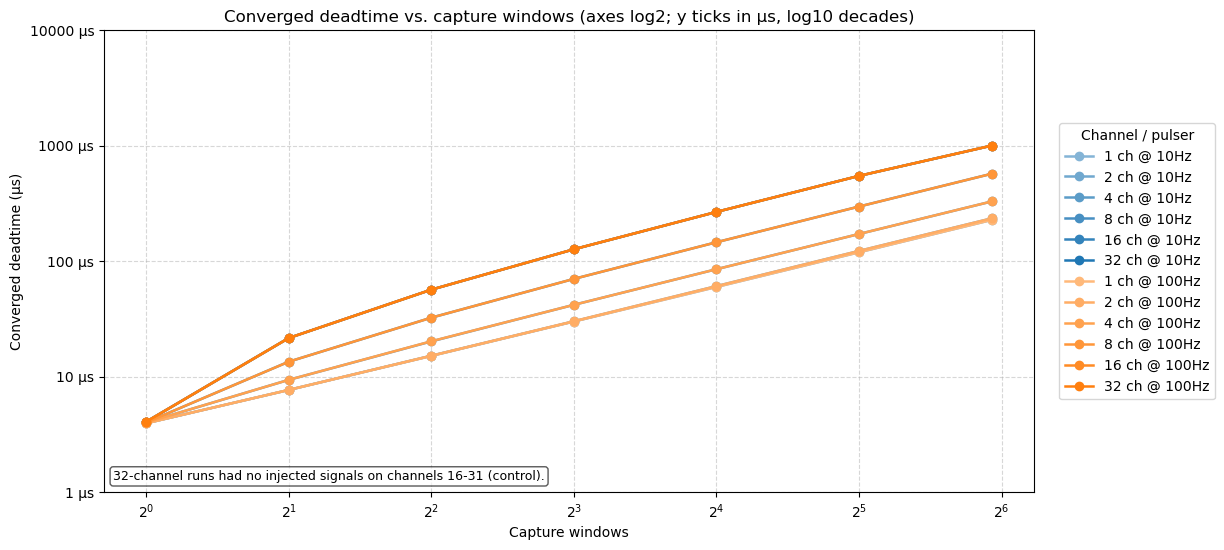

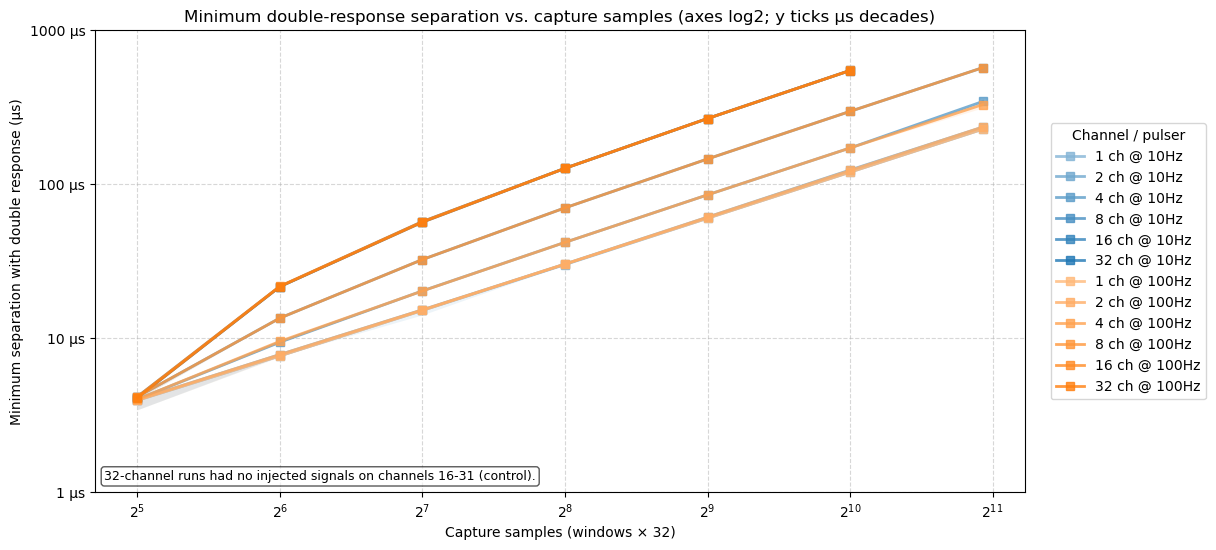

Linear fits for minimum double-response separation (windows on x-axis):
  1 ch @ 10Hz: separation = 0.116 * samples + 0.28
  2 ch @ 10Hz: separation = 0.120 * samples + -0.11
  4 ch @ 10Hz: separation = 0.176 * samples + -3.30
  8 ch @ 10Hz: separation = 0.295 * samples + -5.36
  16 ch @ 10Hz: separation = 0.547 * samples + -13.26
  32 ch @ 10Hz: separation = 0.547 * samples + -13.40
  1 ch @ 100Hz: separation = 0.116 * samples + 0.32
  2 ch @ 100Hz: separation = 0.120 * samples + -0.20
  4 ch @ 100Hz: separation = 0.169 * samples + -1.37
  8 ch @ 100Hz: separation = 0.295 * samples + -5.36
  16 ch @ 100Hz: separation = 0.547 * samples + -13.23
  32 ch @ 100Hz: separation = 0.547 * samples + -13.40


In [4]:
analysis.plot_converged_vs_windows(pulse_rates=PULSER_RATES)
analysis.plot_min_double_vs_windows(pulse_rates=PULSER_RATES)


## Converged separation vs. active channels
Side-by-side comparison of 10 Hz and 100 Hz pulser rates.

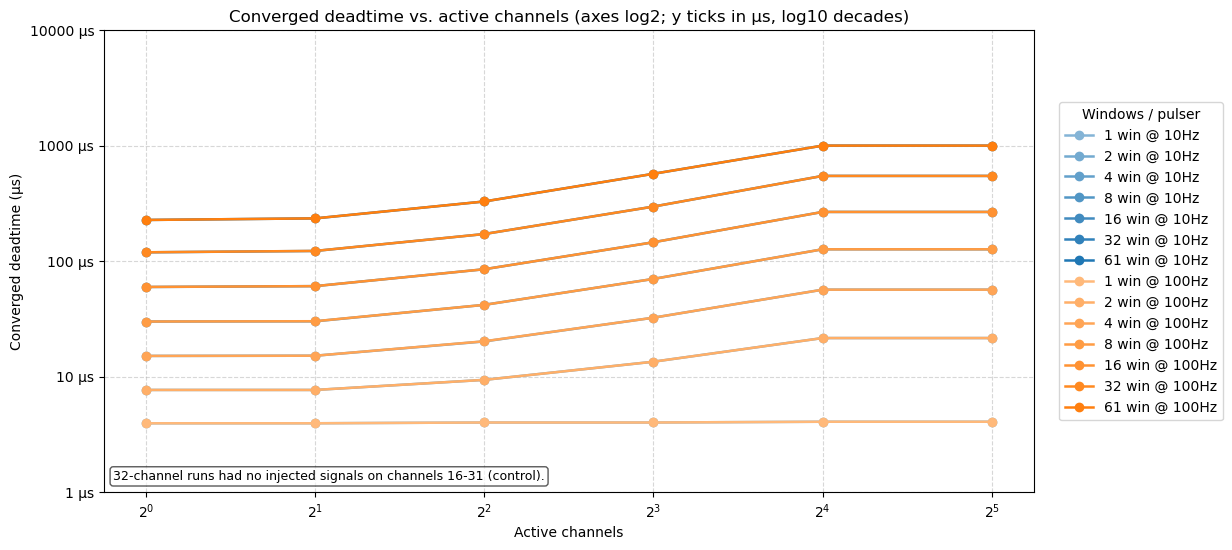

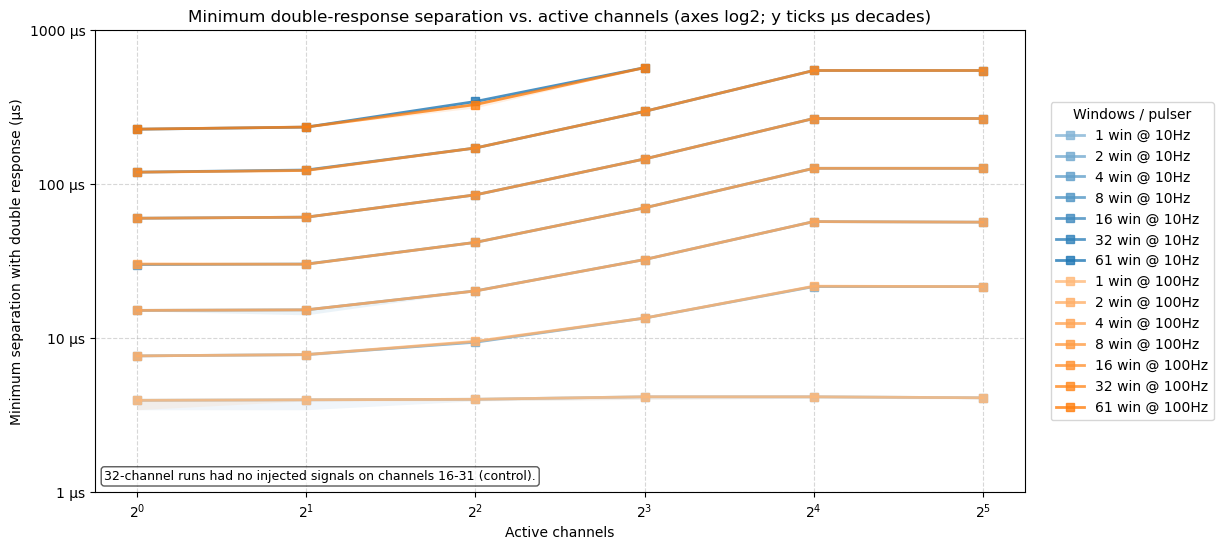

Linear fits for minimum double-response separation (channels on x-axis):
  1 win @ 10Hz: separation = 0.005 * channels + 4.01
  2 win @ 10Hz: separation = 0.496 * channels + 8.39
  4 win @ 10Hz: separation = 1.486 * channels + 17.19
  8 win @ 10Hz: separation = 3.454 * channels + 34.67
  16 win @ 10Hz: separation = 7.382 * channels + 70.03
  32 win @ 10Hz: separation = 15.237 * channels + 140.84
  61 win @ 10Hz: separation = 51.304 * channels + 151.70
  1 win @ 100Hz: separation = 0.005 * channels + 4.01
  2 win @ 100Hz: separation = 0.496 * channels + 8.43
  4 win @ 100Hz: separation = 1.486 * channels + 17.19
  8 win @ 100Hz: separation = 3.450 * channels + 34.73
  16 win @ 100Hz: separation = 7.382 * channels + 70.03
  32 win @ 100Hz: separation = 15.247 * channels + 140.61
  61 win @ 100Hz: separation = 51.142 * channels + 148.51


In [5]:
analysis.plot_converged_vs_channels(pulse_rates=PULSER_RATES)
analysis.plot_min_double_vs_channels(pulse_rates=PULSER_RATES)


In [ ]:
# Zoomed view of converged deadtime vs windows with bounds
rate = 10.0
channel_count = 1
conv = analysis.converged_table()
subset = conv[(conv['pulse_rate_hz']==rate) & (conv['channel_count']==channel_count)]
if subset.empty:
    raise ValueError('No data for selected rate/channel')
subset = subset.sort_values('windows')
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(subset['windows'], subset['converged_deadtime_ns']/1000.0, marker='o', label=f'{int(channel_count)} ch @ {rate:.0f} Hz')
ax.fill_between(subset['windows'], subset['converged_lower_bound_ns']/1000.0, subset['converged_upper_bound_ns']/1000.0, color='C0', alpha=0.2, linewidth=0)
ax.set_xscale('log', base=2)
ax.set_xlabel('Capture windows')
ax.set_ylabel('Converged deadtime (µs)')
ax.set_title('Zoom: Converged deadtime vs capture windows (with bounds)')
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.show()